# Results

In [1]:
%load_ext autoreload
%autoreload 2

Running diagnostics...

Running focused analysis...
Loading and processing results...
Loaded 9 result files.
Found agent names: ['tot' 'fast' 'react' 'reflection' 'slow' 'self_discovery' 'baseline'
 'plan_execute' 'improver']

Aggregating results by agent...

Computing statistical significance...

Saving results to paper_figures-nasa

Agent names in plots: ['baseline', 'fast', 'improver', 'plan_execute', 'react', 'reflection', 'self_discovery', 'slow', 'tot']

Generating requested plots...


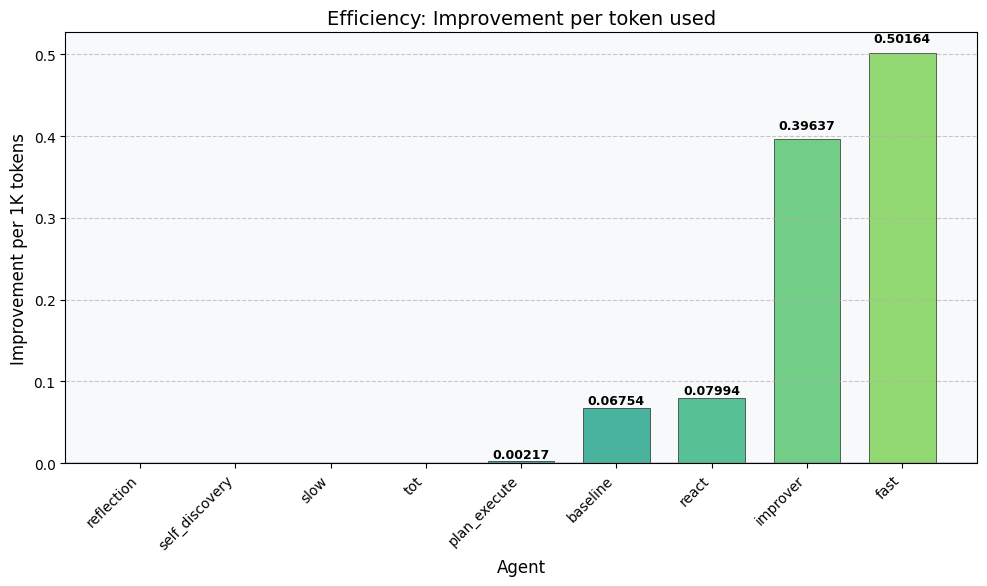

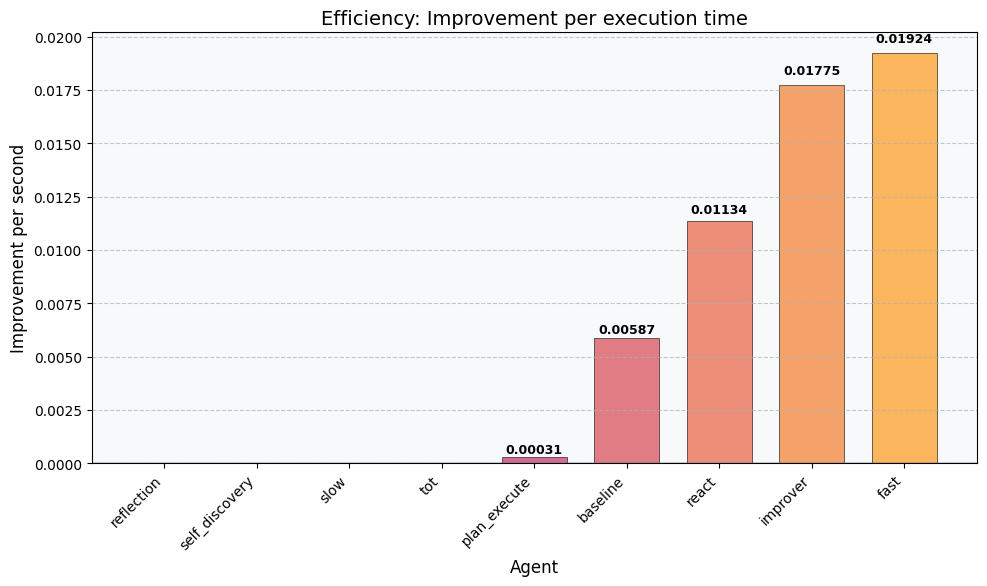

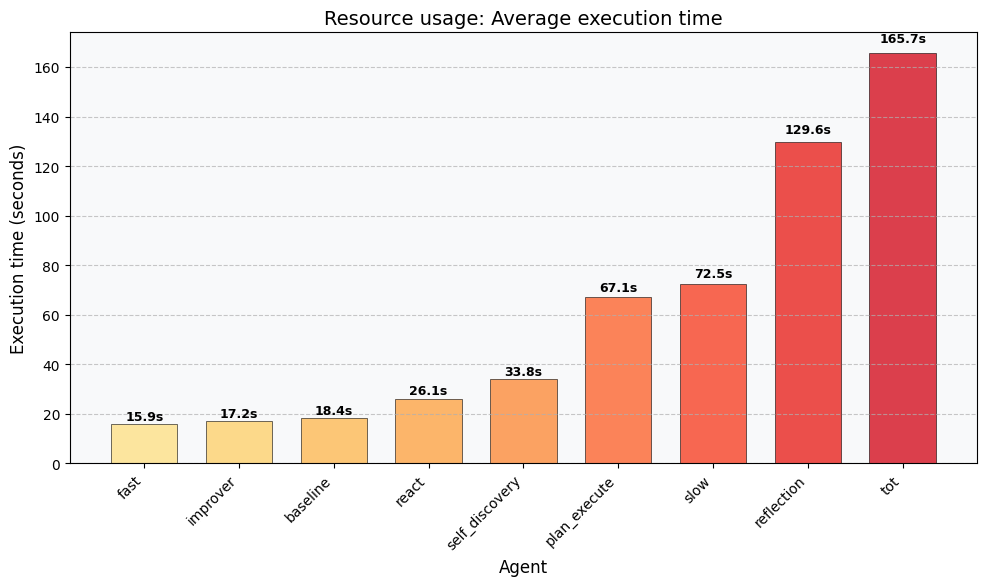

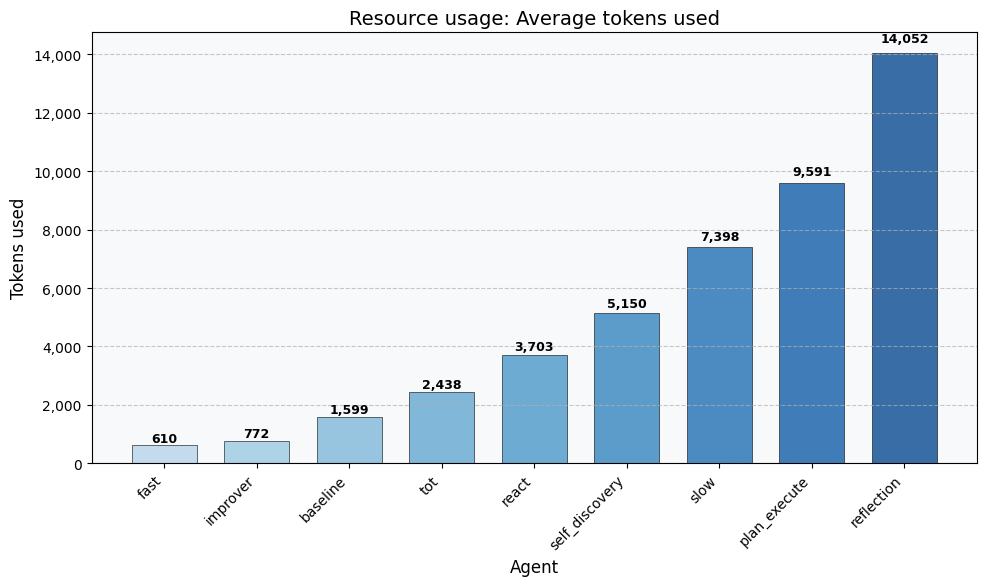

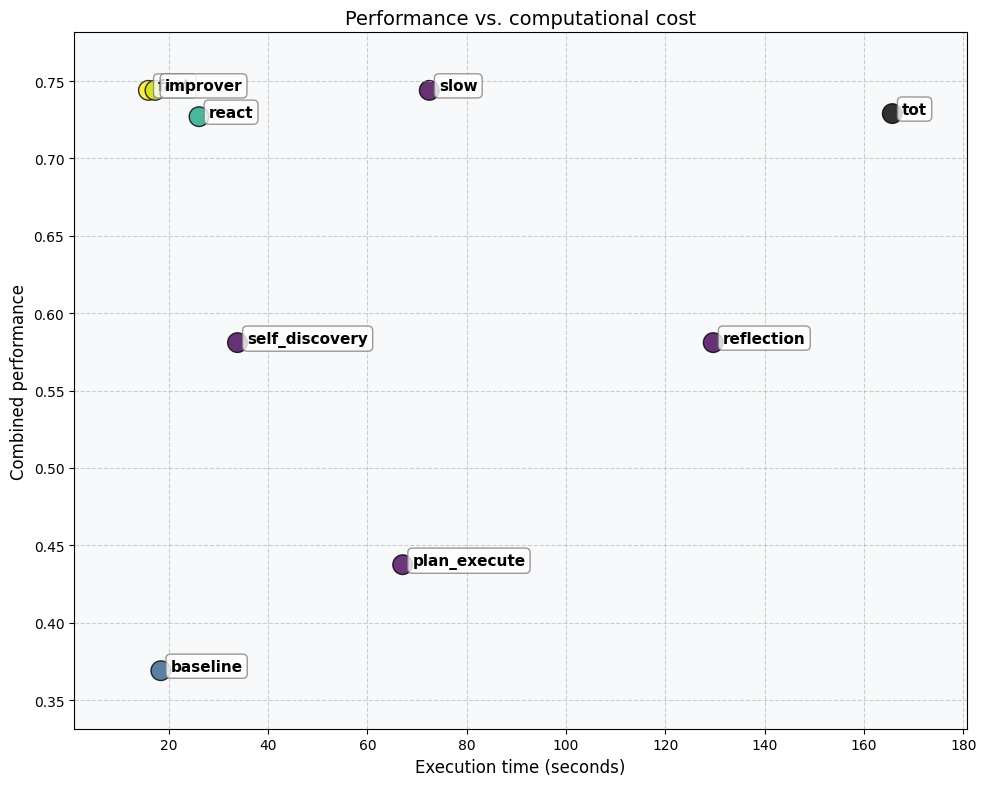


Analysis complete!
        temperature  max_iter  initial_new  final_new  initial_old  final_old  \
count  9.000000e+00       9.0     8.000000   9.000000     8.000000   9.000000   
mean   9.000000e-01       1.0     0.410250   0.554095     0.792500   0.702905   
std    1.177569e-16       0.0     0.108187   0.145693     0.007071   0.197087   
min    9.000000e-01       1.0     0.372000   0.372000     0.790000   0.258000   
25%    9.000000e-01       1.0     0.372000   0.392857     0.790000   0.786000   
50%    9.000000e-01       1.0     0.372000   0.668000     0.790000   0.790000   
75%    9.000000e-01       1.0     0.372000   0.678000     0.790000   0.810000   
max    9.000000e-01       1.0     0.678000   0.678000     0.810000   0.810000   

       improvement_new  improvement_old  generalization_gap_initial  \
count         8.000000         8.000000                    8.000000   
mean          0.129607        -0.100482                    0.382250   
std           0.147650         0.2062

In [ ]:
import os
import glob
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
import warnings

# Set up publication-ready styling
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.figsize'] = (10, 6)

# Set a more modern color palette
COLORS = sns.color_palette("viridis", 10)
FIGURE_DPI = 300

def load_results(results_dir: str = "results") -> pd.DataFrame:
    """
    Load YAML files from the specified directory and extract key evaluation metrics and parameters.

    Parameters
    ----------
    results_dir : str
        Directory containing YAML result files

    Returns
    -------
    pd.DataFrame
        DataFrame with processed results
    """
    files = glob.glob(os.path.join(results_dir, "*.yaml"))
    records = []
    
    for file in files:
        with open(file, "r") as f:
            try:
                data = yaml.safe_load(f)
            except Exception as e:
                warnings.warn(f"Failed to load {file}: {e}")
                continue
                
        # Parse parameters from the filename using regex
        basename = os.path.basename(file)
        pattern = r"^(.*?)_temp_([0-9.]+)_max_iter_(\d+)_llm_([^_]+)_dataset_([^_]+)_.*\.yaml$"
        match = re.match(pattern, basename)
        
        if match:
            agent_from_fname = match.group(1)
            temperature = float(match.group(2))
            max_iter = int(match.group(3))
            llm = match.group(4)
            dataset = match.group(5)
        else:
            agent_from_fname = "unknown"
            temperature = None
            max_iter = None
            llm = None
            dataset = None
        
        # Use agent name from YAML if available, otherwise from filename
        agent = data.get("agent_name", agent_from_fname)
        
        # Extract initial metrics
        initial_new = None
        initial_old = None
        
        if "initial_metrics" in data:
            im = data["initial_metrics"]
            initial_new = im.get("new_distribution")
            initial_old = im.get("old_distribution")
        elif "initial_state" in data:
            metrics = data["initial_state"].get("metrics", {})
            model_old_score = metrics.get("model_old_score", {})
            initial_new = model_old_score.get("on_new_data")
            initial_old = model_old_score.get("on_old_data")
        
        # Extract final metrics
        final_new = None
        final_old = None
        
        if "final_metrics" in data and data["final_metrics"]:
            fm = data["final_metrics"]
            final_new = fm.get("new_distribution")
            final_old = fm.get("old_distribution")
        
        # Mark success if final_metrics is non-empty and contains at least a new_distribution value
        success = bool(final_new is not None)
        
        # Compute improvement if metrics are available
        improvement_new = None
        improvement_old = None
        generalization_gap_initial = None
        generalization_gap_final = None
        
        if initial_new is not None and final_new is not None:
            improvement_new = final_new - initial_new
        
        if initial_old is not None and final_old is not None:
            improvement_old = final_old - initial_old
            
        if initial_old is not None and initial_new is not None:
            generalization_gap_initial = initial_old - initial_new
            
        if final_old is not None and final_new is not None:
            generalization_gap_final = final_old - final_new
        
        # Extract runtime statistics (execution time and tokens used)
        exec_time = None
        tokens_used = None
        iterations = None
        
        if "runtime_statistics" in data:
            rt = data["runtime_statistics"]
            exec_time = rt.get("total_time_seconds")
            tokens_used = rt.get("tokens_used")
            iterations = rt.get("iterations")
        
        records.append({
            "file": basename,
            "agent": agent,
            "temperature": temperature,
            "max_iter": max_iter,
            "llm": llm,
            "dataset": dataset,
            "initial_new": initial_new,
            "final_new": final_new,
            "initial_old": initial_old,
            "final_old": final_old,
            "improvement_new": improvement_new,
            "improvement_old": improvement_old,
            "generalization_gap_initial": generalization_gap_initial,
            "generalization_gap_final": generalization_gap_final,
            "exec_time": exec_time,
            "tokens_used": tokens_used,
            "iterations": iterations,
            "success": success,
        })
    
    df = pd.DataFrame(records)
    return df

def aggregate_results(df: pd.DataFrame, group_by: List[str] = ["agent"]) -> pd.DataFrame:
    """
    Group results by specified columns and aggregate metrics.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with processed results
    group_by : List[str]
        Columns to group by (default: ["agent"])

    Returns
    -------
    pd.DataFrame
        Aggregated metrics per group
    """
    # Ensure group_by columns are present in df
    valid_cols = [col for col in group_by if col in df.columns]
    if not valid_cols:
        warnings.warn(f"None of the specified columns {group_by} found in DataFrame. Defaulting to 'agent'.")
        valid_cols = ["agent"]
    
    # Group by valid columns
    grouped = df.groupby(valid_cols)
    
    aggregated = []
    for names, group in grouped:
        if not isinstance(names, tuple):
            names = (names,)
            
        total_runs = len(group)
        success_runs = group[group["success"] == True]
        num_success = len(success_runs)
        success_rate = num_success / total_runs if total_runs > 0 else 0
        
        # Calculate means and standard errors over successful runs
        metrics = ['final_new', 'final_old', 'improvement_new', 'improvement_old', 
                   'generalization_gap_initial', 'generalization_gap_final',
                   'exec_time', 'tokens_used', 'iterations']
        
        # FIX: Use the actual group values for each aggregated entry
        agg_data = {}
        for i, col in enumerate(valid_cols):
            agg_data[col] = names[i]  # Use the actual group value, not the column name
            
        agg_data.update({
            "total_runs": total_runs,
            "successful_runs": num_success,
            "success_rate": success_rate
        })
        
        for metric in metrics:
            if num_success > 0 and metric in success_runs.columns:
                values = success_runs[metric].dropna()
                if not values.empty:
                    agg_data[f"avg_{metric}"] = values.mean()
                    agg_data[f"std_{metric}"] = values.std()
                    # agg_data[f"se_{metric}"] = values.std() / np.sqrt(len(values))
                    agg_data[f"se_{metric}"] = values.std(ddof=0) / np.sqrt(len(values))

                    agg_data[f"min_{metric}"] = values.min()
                    agg_data[f"max_{metric}"] = values.max()
        
        # Calculate efficiency metrics
        if 'avg_improvement_new' in agg_data and 'avg_tokens_used' in agg_data and agg_data['avg_tokens_used'] > 0:
            agg_data['improvement_per_token'] = agg_data['avg_improvement_new'] / agg_data['avg_tokens_used'] * 1000  # Scale for readability
            
        if 'avg_improvement_new' in agg_data and 'avg_exec_time' in agg_data and agg_data['avg_exec_time'] > 0:
            agg_data['improvement_per_second'] = agg_data['avg_improvement_new'] / agg_data['avg_exec_time']
                    
        aggregated.append(agg_data)
    
    # Create a DataFrame from aggregated data
    agg_df = pd.DataFrame(aggregated)
    
    # Compute combined metrics
    if "avg_final_new" in agg_df.columns and "avg_final_old" in agg_df.columns:
        # Combined accuracy (balanced across distributions)
        agg_df["avg_final_combined"] = (agg_df["avg_final_new"] + agg_df["avg_final_old"]) / 2.0
        
        # Standard error for combined metric
        if "se_final_new" in agg_df.columns and "se_final_old" in agg_df.columns:
            # Propagation of error for average
            agg_df["se_final_combined"] = np.sqrt(
                (agg_df["se_final_new"]**2 + agg_df["se_final_old"]**2) / 4
            )
    
    return agg_df

def compute_statistical_significance(agg_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute statistical significance between different agents.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated results DataFrame
    
    Returns
    -------
    pd.DataFrame
        DataFrame with pairwise p-values for improvement metrics
    """
    # We can only compute this if we have more than one agent
    if len(agg_df) <= 1 or 'agent' not in agg_df.columns:
        return pd.DataFrame()
    
    agents = agg_df['agent'].unique()
    metrics = ['final_new', 'final_old', 'improvement_new', 'final_combined']
    
    results = []
    
    for i, agent1 in enumerate(agents):
        for j, agent2 in enumerate(agents):
            if i >= j:  # Only compute upper triangle
                continue
                
            row = {'agent1': agent1, 'agent2': agent2}
            
            for metric in metrics:
                metric_name = f'avg_{metric}'
                if metric_name not in agg_df.columns:
                    continue
                    
                # Get the actual data from the original DataFrame
                agent1_data = agg_df[agg_df['agent'] == agent1]
                agent2_data = agg_df[agg_df['agent'] == agent2]
                
                # Skip if either agent doesn't have this metric
                if (metric_name not in agent1_data.columns or 
                    metric_name not in agent2_data.columns or
                    pd.isna(agent1_data[metric_name].iloc[0]) or 
                    pd.isna(agent2_data[metric_name].iloc[0])):
                    continue
                
                # Perform t-test
                mean1 = agent1_data[metric_name].iloc[0]
                std1 = agent1_data.get(f'std_{metric}', pd.Series([0])).iloc[0]
                n1 = agent1_data['successful_runs'].iloc[0]
                
                mean2 = agent2_data[metric_name].iloc[0]
                std2 = agent2_data.get(f'std_{metric}', pd.Series([0])).iloc[0]
                n2 = agent2_data['successful_runs'].iloc[0]
                
                # Skip if not enough data
                if n1 <= 1 or n2 <= 1 or std1 == 0 or std2 == 0:
                    continue
                
                # Calculate t-statistic and p-value
                # Using Welch's t-test for unequal variances
                t_stat, p_value = stats.ttest_ind_from_stats(
                    mean1=mean1, std1=std1, nobs1=n1,
                    mean2=mean2, std2=std2, nobs2=n2,
                    equal_var=False
                )
                
                row[f'p_{metric}'] = p_value
                row[f'significant_{metric}'] = p_value < 0.05
                
            results.append(row)
    
    return pd.DataFrame(results)

def plot_efficiency_metrics(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create individual efficiency plots.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    """
    if 'agent' not in agg_df.columns:
        warnings.warn("'agent' column not found in aggregated DataFrame")
        return
    
    # Get agent names for x-axis
    agent_names = agg_df['agent'].tolist()
    
    # Save function
    def save_fig(name):
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, f"{name}.pdf"), dpi=FIGURE_DPI, bbox_inches='tight')
    
    # Plot 1: Improvement per token
    if 'improvement_per_token' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['improvement_per_token'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors
        bars = ax.bar(
            sorted_x, 
            sorted_df['improvement_per_token'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{height:.5f}", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Improvement per 1K tokens', fontsize=12)
        ax.set_title('Efficiency: Improvement per token used', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add a horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("improvement_per_token")
        plt.show()
    
    # Plot 2: Improvement per second
    if 'improvement_per_second' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['improvement_per_second'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors
        bars = ax.bar(
            sorted_x, 
            sorted_df['improvement_per_second'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{height:.5f}", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Improvement per second', fontsize=12)
        ax.set_title('Efficiency: Improvement per execution time', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add a horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("improvement_per_second")
        plt.show()

def plot_resource_usage(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create individual resource usage plots without error bars.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    """
    if 'agent' not in agg_df.columns:
        warnings.warn("'agent' column not found in aggregated DataFrame")
        return
    
    # Get agent names for x-axis
    agent_names = agg_df['agent'].tolist()
    
    # Save function
    def save_fig(name):
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            plt.savefig(os.path.join(output_dir, f"{name}.pdf"), dpi=FIGURE_DPI, bbox_inches='tight')
    
    # Plot 1: Execution Time
    if 'avg_exec_time' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.YlOrRd(np.linspace(0.2, 0.8, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['avg_exec_time'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors (no error bars)
        bars = ax.bar(
            sorted_x, 
            sorted_df['avg_exec_time'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{height:.1f}s", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Execution time (seconds)', fontsize=12)
        ax.set_title('Resource usage: Average execution time', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("execution_time")
        plt.show()
    
    # Plot 2: Tokens Used
    if 'avg_tokens_used' in agg_df.columns:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create a gradient color bar based on values
        colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(agg_df)))
        
        # Sort the data for better visualization
        sorted_idx = agg_df['avg_tokens_used'].fillna(0).argsort()
        sorted_df = agg_df.iloc[sorted_idx]
        sorted_agents = [agent_names[i] for i in sorted_idx]
        sorted_x = np.arange(len(sorted_df))
        
        # Create bars with gradient colors (no error bars)
        bars = ax.bar(
            sorted_x, 
            sorted_df['avg_tokens_used'], 
            color=colors, 
            width=0.7,
            edgecolor='black',
            linewidth=0.5,
            alpha=0.8
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if not np.isnan(height) and height > 0:
                ax.text(
                    bar.get_x() + bar.get_width()/2, 
                    height * 1.02, 
                    f"{int(height):,}", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    fontweight='bold',
                    color='black'
                )
        
        # Styling
        ax.set_xlabel('Agent', fontsize=12)
        ax.set_ylabel('Tokens used', fontsize=12)
        ax.set_title('Resource usage: Average tokens used', fontsize=14)
        ax.set_xticks(sorted_x)
        ax.set_xticklabels(sorted_agents, rotation=45, ha='right')
        
        # Add grid only for y-axis
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Format y-axis with commas for thousands
        ax.get_yaxis().set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
        
        # Set background color
        ax.set_facecolor('#f8f9fa')
        
        plt.tight_layout()
        save_fig("tokens_used")
        plt.show()

def plot_performance_vs_cost(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create a simplified performance vs computational cost plot with just points.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    """
    if 'agent' not in agg_df.columns or 'avg_final_combined' not in agg_df.columns or 'avg_exec_time' not in agg_df.columns:
        warnings.warn("Required metrics not found for performance vs cost plot")
        return
    
    # Drop rows with missing values
    valid_df = agg_df.dropna(subset=['avg_final_combined', 'avg_exec_time'])
    if len(valid_df) < 2:
        warnings.warn("Not enough valid data points for performance vs cost plot")
        return
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Compute efficiency metric for color gradient
    if 'improvement_per_second' in valid_df.columns:
        efficiency = valid_df['improvement_per_second']
        norm = plt.Normalize(efficiency.min(), efficiency.max())
        colors = plt.cm.viridis(norm(efficiency))
    else:
        # Use sequential colors if efficiency not available
        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(valid_df)))
    
    # Get agent names
    agent_names = valid_df['agent'].tolist()
    
    # Create scatter plot with improved styling
    scatter = ax.scatter(
        valid_df['avg_exec_time'],
        valid_df['avg_final_combined'],
        s=200,  # Larger markers
        c=colors,
        alpha=0.8,
        edgecolors='black',
        linewidths=1
    )
    
    # Add agent labels with nice styling
    for i, agent in enumerate(agent_names):
        ax.annotate(
            agent,
            (valid_df['avg_exec_time'].iloc[i], valid_df['avg_final_combined'].iloc[i]),
            xytext=(7, 0),
            textcoords='offset points',
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    # Styling
    ax.set_xlabel('Execution time (seconds)', fontsize=12)
    ax.set_ylabel('Combined performance', fontsize=12)
    ax.set_title('Performance vs. computational cost', fontsize=14)
    
    # Set axis limits with some padding
    x = valid_df['avg_exec_time']
    y = valid_df['avg_final_combined']
    x_padding = (x.max() - x.min()) * 0.1
    y_padding = (y.max() - y.min()) * 0.1
    ax.set_xlim(x.min() - x_padding, x.max() + x_padding)
    ax.set_ylim(y.min() - y_padding, y.max() + y_padding)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Set background color
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    
    # Save if output_dir provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, "performance_vs_cost.pdf"), dpi=FIGURE_DPI, bbox_inches='tight')
    
    plt.show()

def plot_focused_metrics(agg_df: pd.DataFrame, output_dir: Optional[str] = None, sig_df: Optional[pd.DataFrame] = None):
    """
    Generate the focused plots requested.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame
    output_dir : str, optional
        Directory to save plots
    sig_df : pd.DataFrame, optional
        DataFrame with statistical significance information
    """
    # 1. Efficiency plots
    plot_efficiency_metrics(agg_df, output_dir)
    
    # 2. Resource usage plots
    plot_resource_usage(agg_df, output_dir)
    
    # 3. Performance vs cost
    plot_performance_vs_cost(agg_df, output_dir)

def diagnose_data(results_dir="results"):
    """
    Diagnostic function to check agent names in the data pipeline.
    """
    print("=" * 50)
    print("DIAGNOSTIC INFORMATION")
    print("=" * 50)
    
    # Load raw files
    files = glob.glob(os.path.join(results_dir, "*.yaml"))
    print(f"Found {len(files)} YAML files")
    
    # Sample a few files
    print("\nSAMPLE AGENT NAMES FROM FILES:")
    for file in files[:5]:  # Check first 5 files
        with open(file, "r") as f:
            try:
                data = yaml.safe_load(f)
                agent_name = data.get("agent_name", "Not found")
                print(f"  - {os.path.basename(file)}: agent_name = {agent_name}")
            except Exception as e:
                print(f"  - {os.path.basename(file)}: ERROR - {str(e)}")
    
    # Load and check the DataFrame
    df = load_results(results_dir)
    print("\nLOADED DATAFRAME AGENT COLUMN:")
    if 'agent' in df.columns:
        unique_agents = df['agent'].unique()
        print(f"  - Unique agent values: {unique_agents}")
        print(f"  - Count: {len(unique_agents)}")
        print(f"  - Example rows:")
        for _, row in df.head(3).iterrows():
            print(f"    * {row['file']} -> agent = {row['agent']}")
    else:
        print("  - No 'agent' column found in DataFrame!")
    
    # Check aggregated DataFrame
    agg_df = aggregate_results(df)
    print("\nAGGREGATED DATAFRAME:")
    if 'agent' in agg_df.columns:
        print(f"  - Agent column values: {agg_df['agent'].tolist()}")
        print(f"  - Agent column dtype: {agg_df['agent'].dtype}")
    else:
        print("  - No 'agent' column found in aggregated DataFrame!")
    
    print("\nDATAFRAME INFO:")
    print("  - Original DataFrame:")
    print(df.info())
    print("\n  - Aggregated DataFrame:")
    print(agg_df.info())
    
    print("=" * 50)
    return df, agg_df

def analyze_results(results_dir="results", output_dir="paper_figures", dataset=None):
    """
    Focused analysis pipeline that generates selected visualizations.
    
    Parameters
    ----------
    results_dir : str
        Directory containing YAML result files
    output_dir : str
        Directory to save generated figures
    """
    # Load and process results
    print("Loading and processing results...")
    df = load_results(results_dir)
    if dataset:
        df = df[df['dataset'] == dataset]

    if df.empty:
        print("No valid results found.")
        return
    
    print(f"Loaded {len(df)} result files.")
    print(f"Found agent names: {df['agent'].unique()}")
    
    # Perform aggregation by agent
    print("\nAggregating results by agent...")
    agg_df = aggregate_results(df)
    
    if 'avg_final_combined' not in agg_df.columns:
        print("Computing combined metrics...")
        # Compute combined metrics if not already done
        if "avg_final_new" in agg_df.columns and "avg_final_old" in agg_df.columns:
            agg_df["avg_final_combined"] = (agg_df["avg_final_new"] + agg_df["avg_final_old"]) / 2.0
            # Calculate standard error for combined metric
            if "se_final_new" in agg_df.columns and "se_final_old" in agg_df.columns:
                agg_df["se_final_combined"] = np.sqrt(
                    (agg_df["se_final_new"]**2 + agg_df["se_final_old"]**2) / 4
                )
            else:
                agg_df["se_final_combined"] = 0.01  # Default value if SE not available
    
    # Compute statistical significance for comparison
    print("\nComputing statistical significance...")
    sig_df = compute_statistical_significance(agg_df)
    
    # Create output directory
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        print(f"\nSaving results to {output_dir}")
    
    # Print the agent names to be used in plotting for verification
    print(f"\nAgent names in plots: {agg_df['agent'].tolist()}")
    
    # Generate requested plots
    print("\nGenerating requested plots...")
    plot_focused_metrics(agg_df, output_dir, sig_df)
    
    # Save processed DataFrames for further analysis
    if output_dir:
        df.to_csv(os.path.join(output_dir, "detailed_results.csv"), index=False)
        agg_df.to_csv(os.path.join(output_dir, "aggregated_results.csv"), index=False)
    
    print("\nAnalysis complete!")
    return df, agg_df, sig_df

# Main execution
# if __name__ == "__main__":
# Run the diagnostic function first
print("Running diagnostics...")
# df, agg_df = diagnose_data("results")

# Then run the focused analysis pipeline
print("\nRunning focused analysis...")
# df, agg_df, sig_df = analyze_results("results", "paper_figures")

dataset = 'nasa'  # Change this to the desired dataset, e.g., 'healthcare', 'nasa-FD002', etc.
df, agg_df, sig_df = analyze_results("results", f"paper_figures-{dataset}", dataset) #ok
# df, agg_df, sig_df = analyze_results("results", "paper_figures", dataset) #ok
# df, agg_df, sig_df = analyze_results("results", "paper_figures", 'dataset') #ok


# df, agg_df, sig_df = analyze_results("results", "paper_figures_nasa-FD002", dataset) #ok
# df, agg_df, sig_df = analyze_results("results", "paper_figures_nasa", 'dataset') # ok
print(df.describe())

print("\nAggregated metrics per agent:")
print(agg_df)

Loading and processing results...
Loaded 9 result files.
Found agent names: ['fast' 'self_discovery' 'reflection' 'react' 'slow' 'improver' 'baseline'
 'tot' 'plan_execute']

Aggregating results by agent...

Computing statistical significance...

Saving results to paper_figures-healthcare

Agent names in plots: ['baseline', 'fast', 'improver', 'plan_execute', 'react', 'reflection', 'self_discovery', 'slow', 'tot']

Generating requested plots...


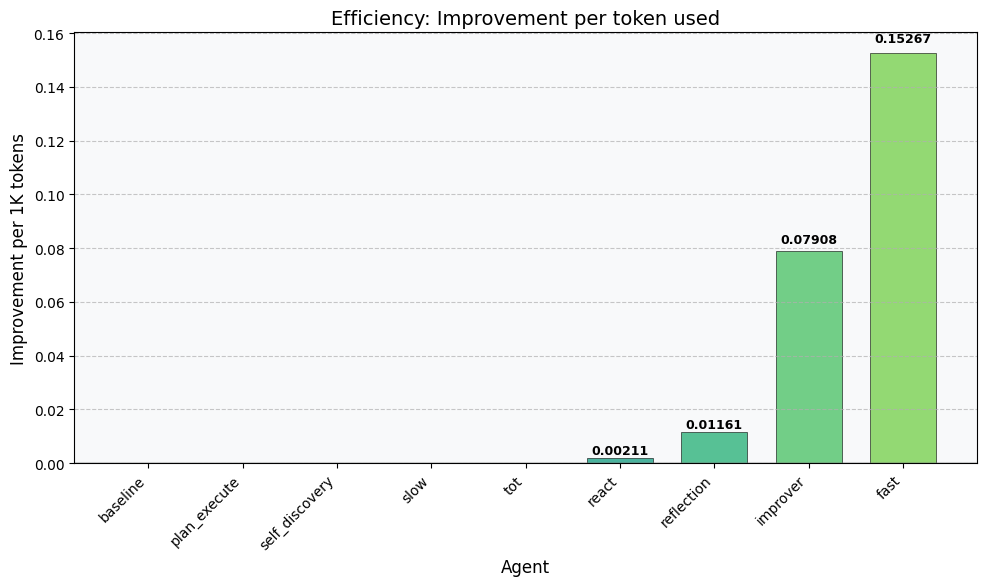

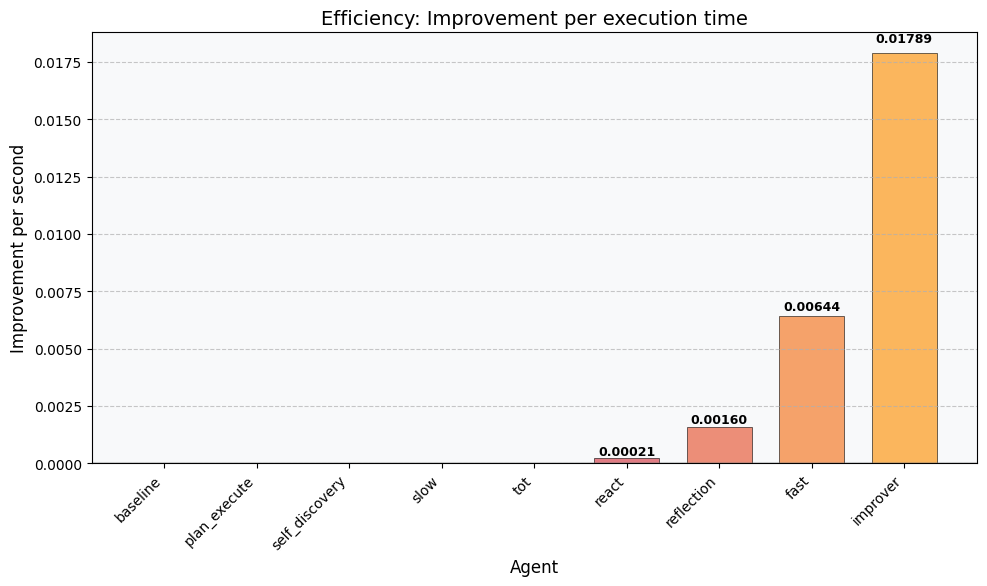

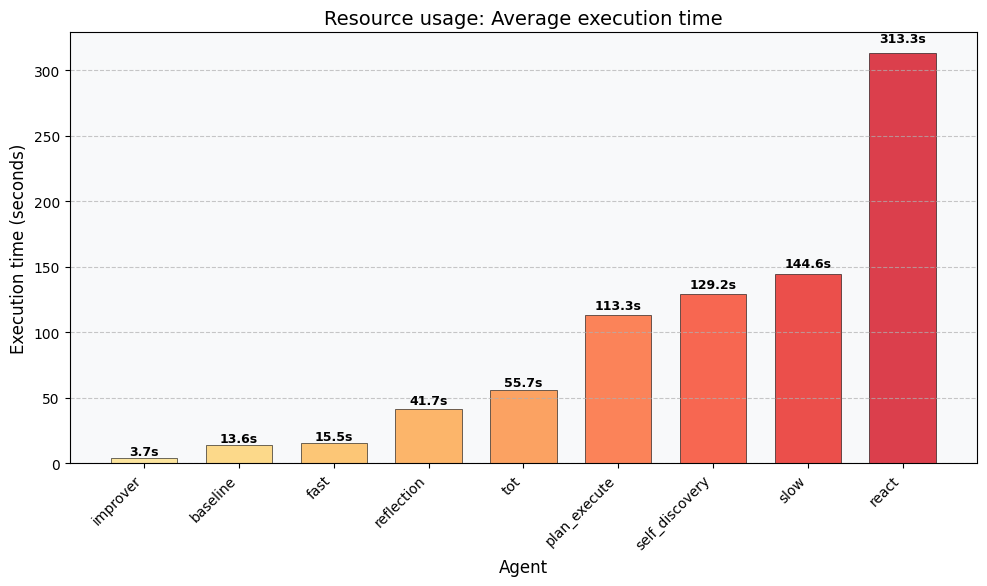

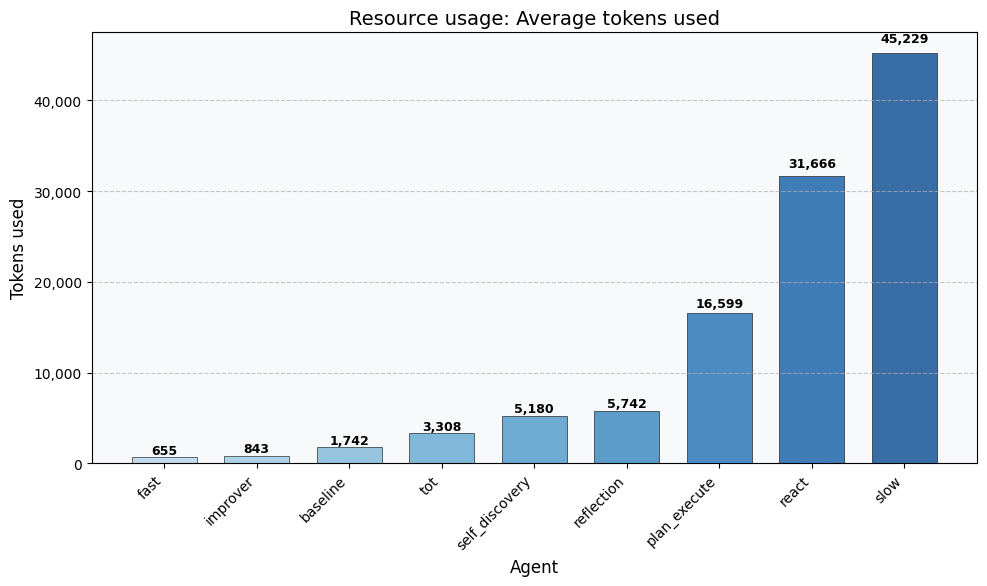

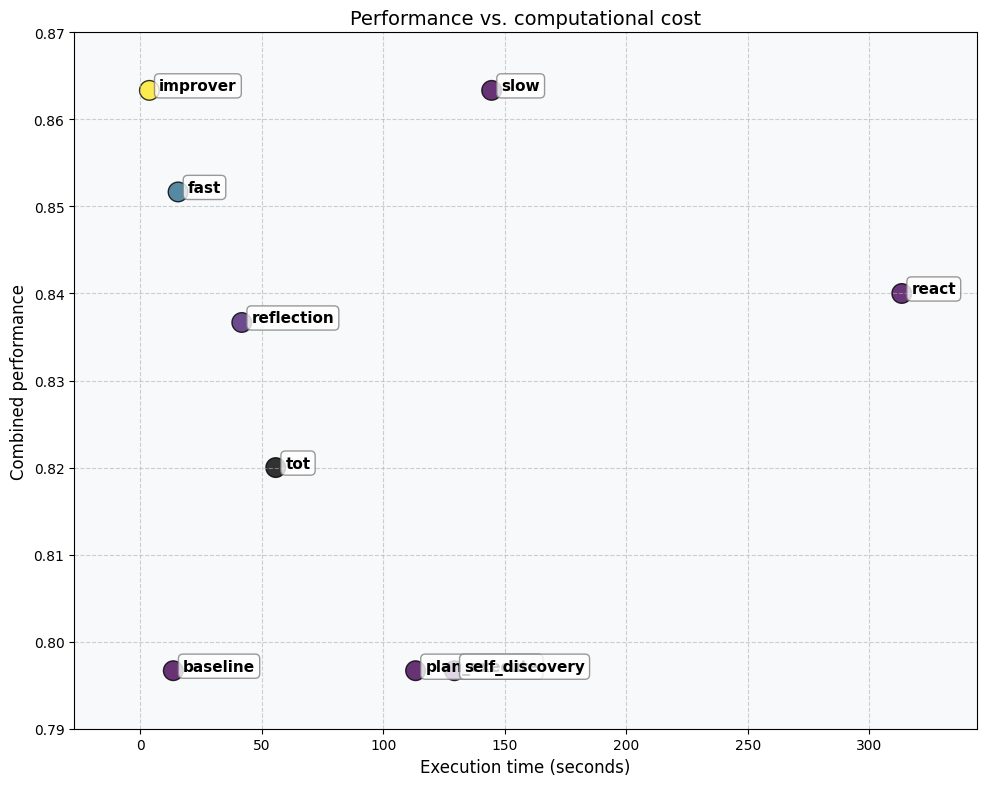


Analysis complete!
Loading and processing results...
Loaded 9 result files.
Found agent names: ['plan_execute' 'baseline' 'fast' 'improver' 'self_discovery' 'slow' 'tot'
 'react' 'reflection']

Aggregating results by agent...

Computing statistical significance...

Saving results to paper_figures-eligibility

Agent names in plots: ['baseline', 'fast', 'improver', 'plan_execute', 'react', 'reflection', 'self_discovery', 'slow', 'tot']

Generating requested plots...


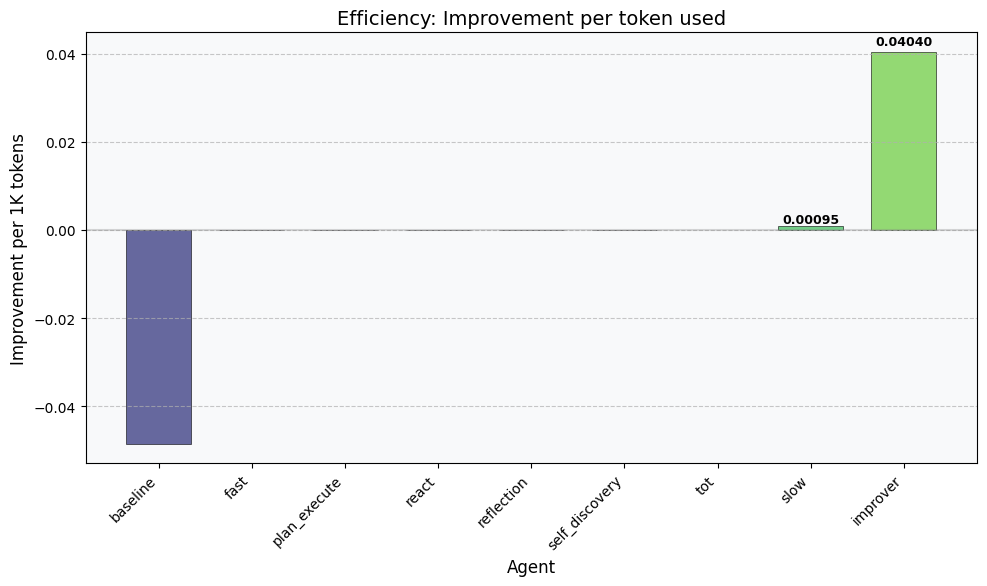

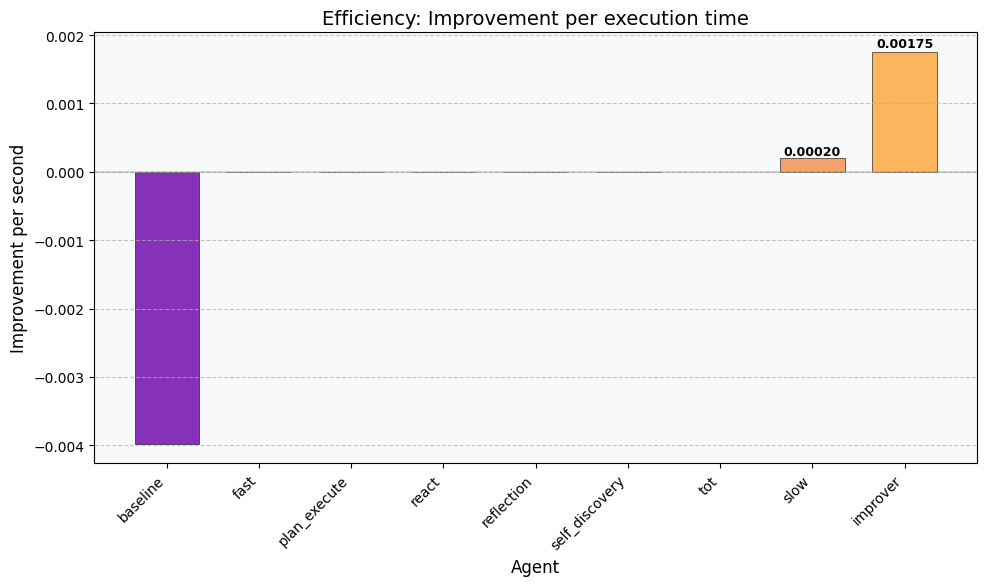

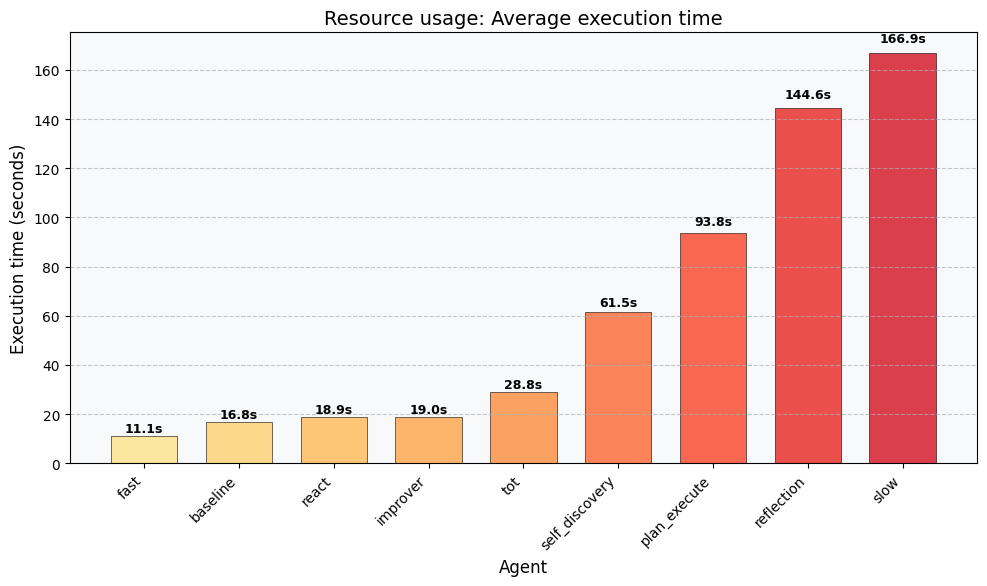

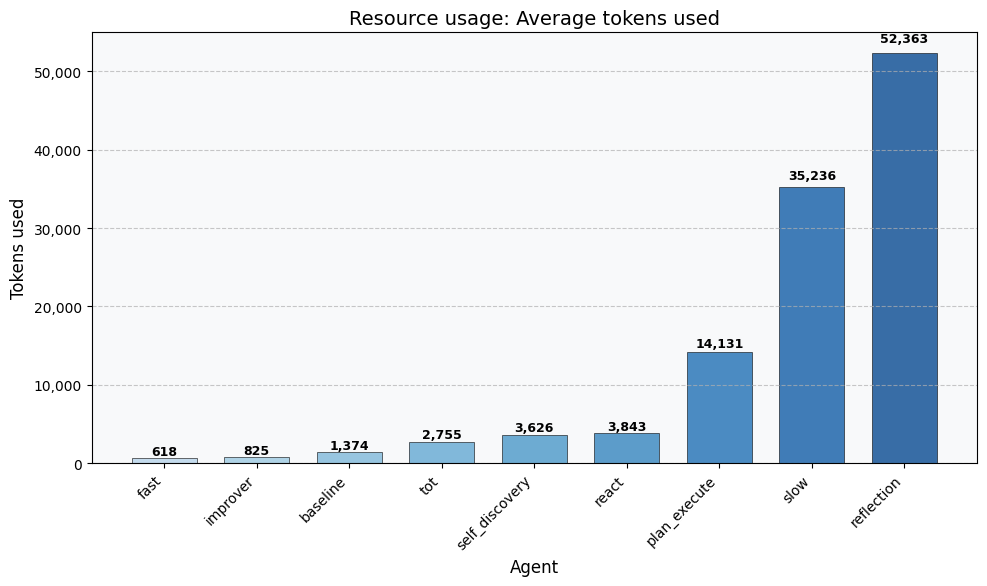

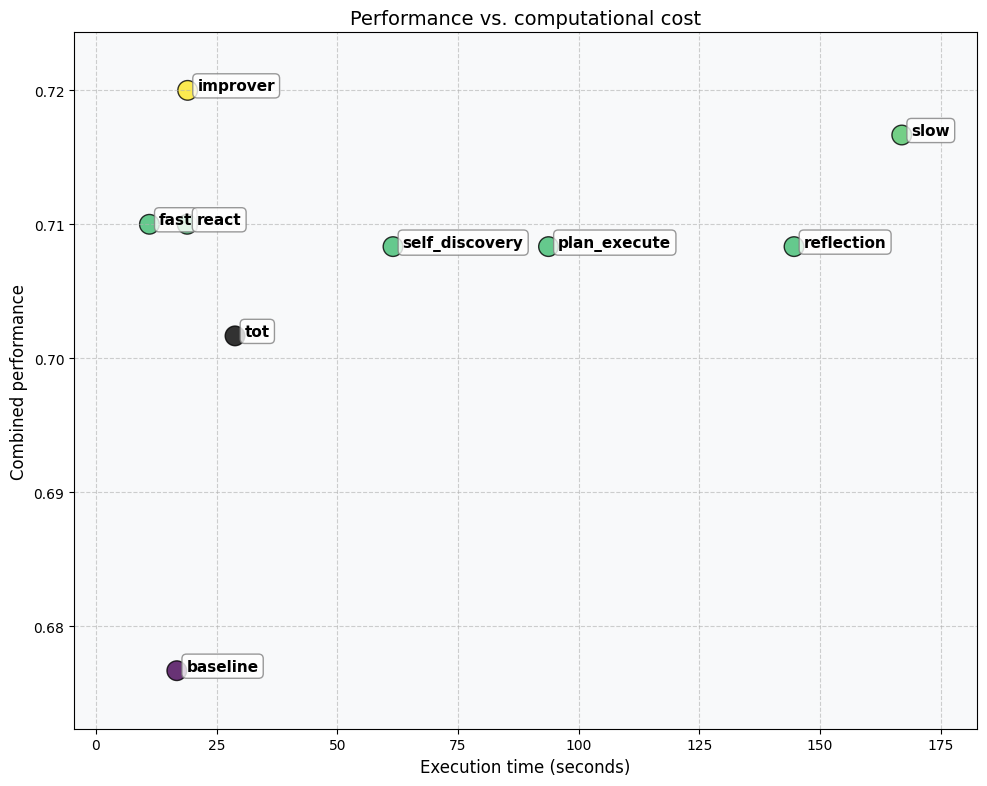


Analysis complete!
Loading and processing results...
Loaded 9 result files.
Found agent names: ['tot' 'improver' 'self_discovery' 'reflection' 'fast' 'slow' 'baseline'
 'react' 'plan_execute']

Aggregating results by agent...

Computing statistical significance...

Saving results to paper_figures-financial

Agent names in plots: ['baseline', 'fast', 'improver', 'plan_execute', 'react', 'reflection', 'self_discovery', 'slow', 'tot']

Generating requested plots...


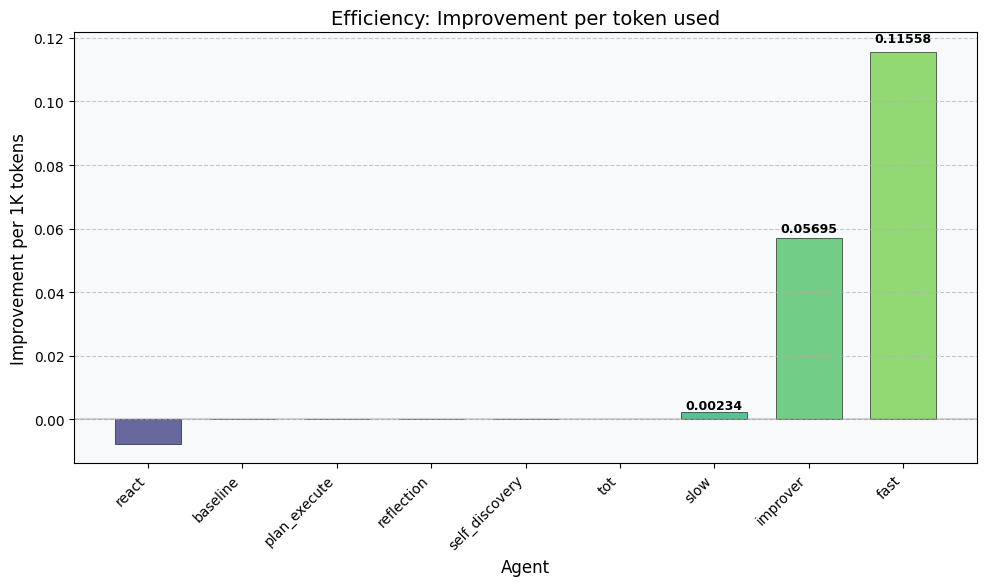

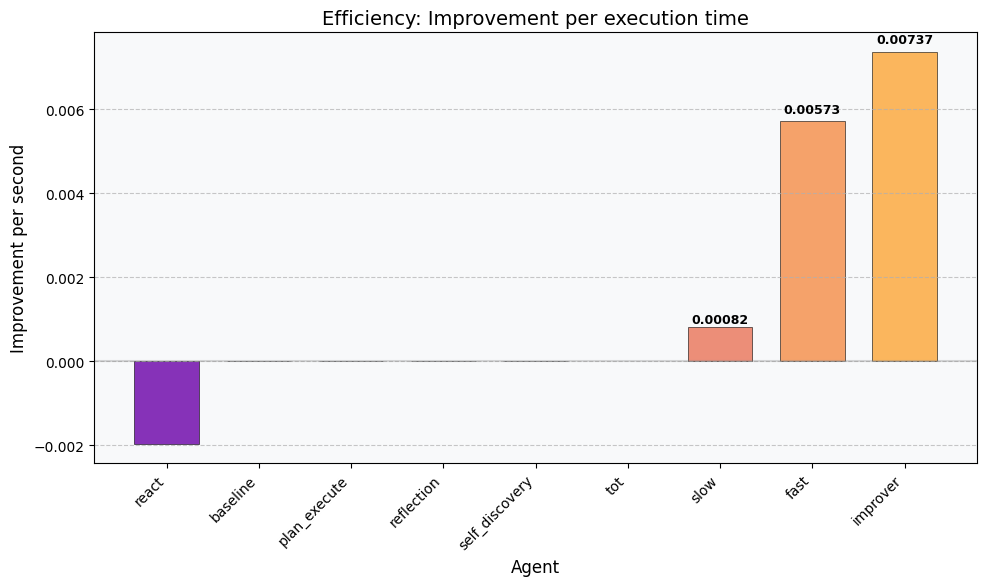

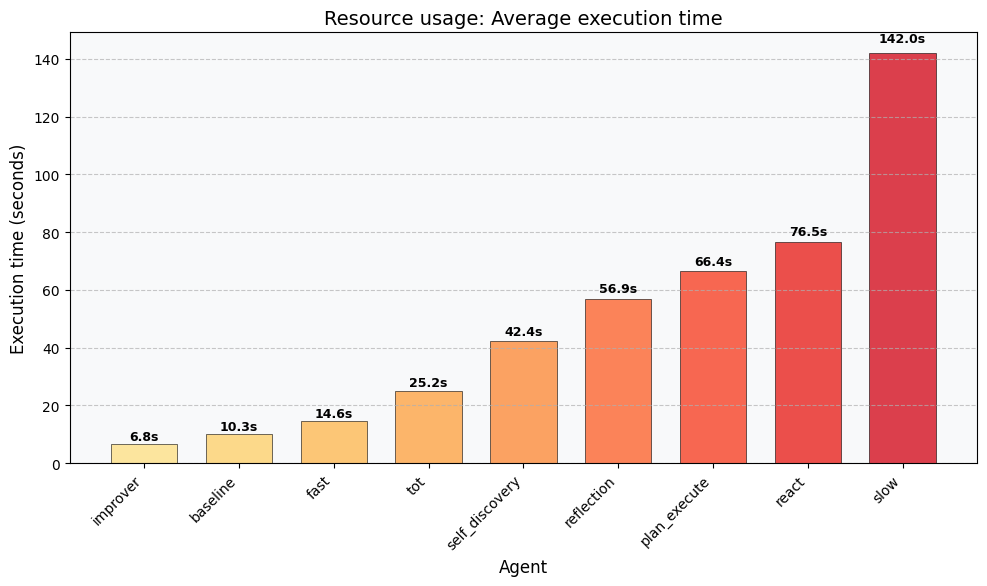

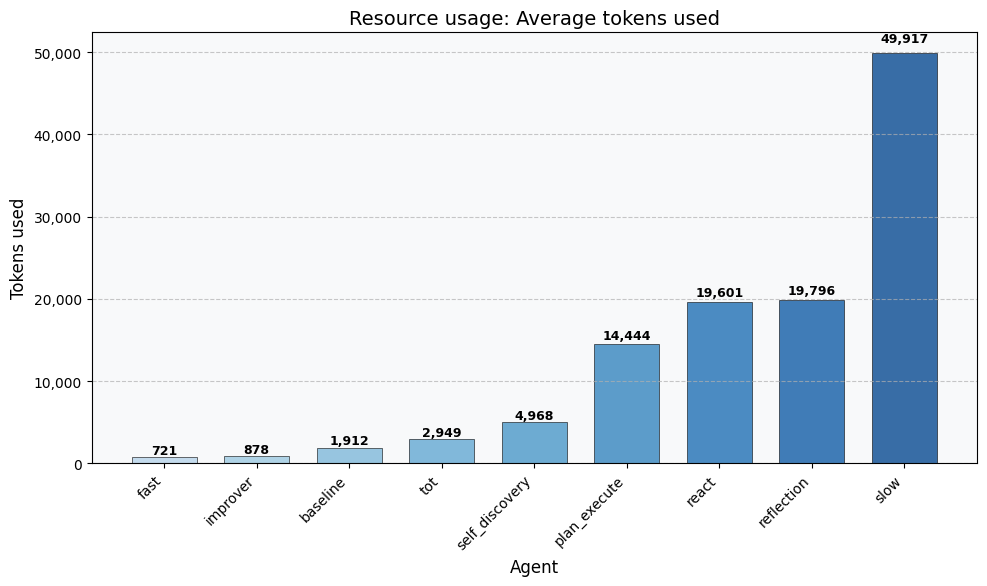

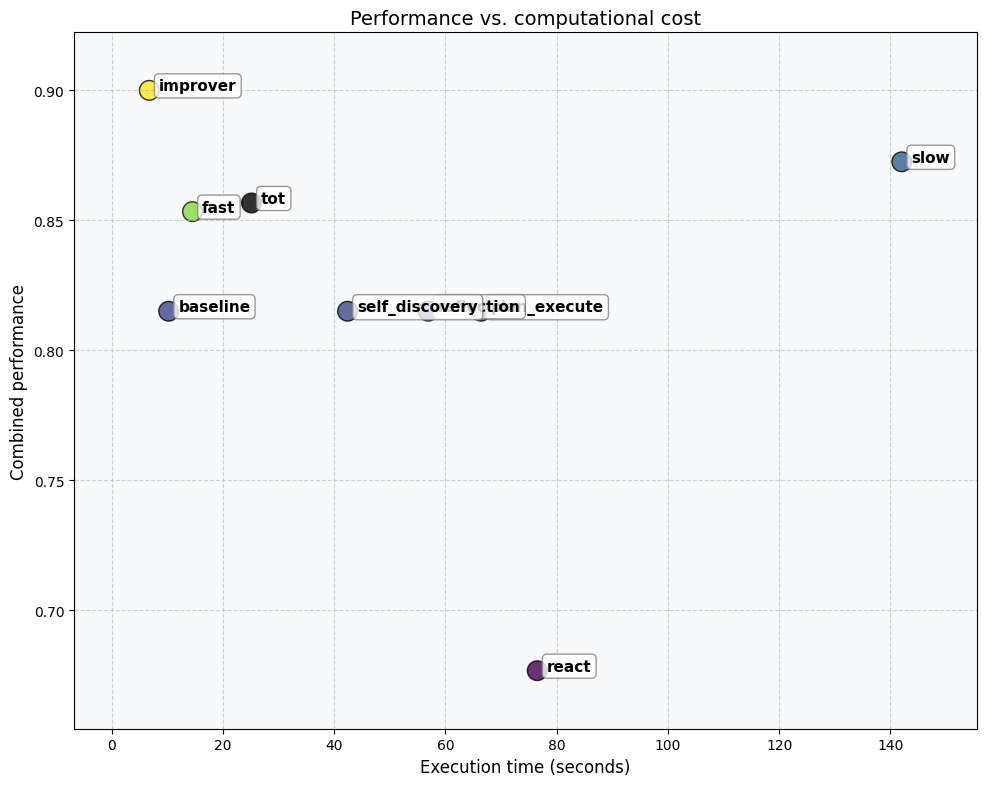


Analysis complete!
Loading and processing results...
Loaded 9 result files.
Found agent names: ['tot' 'fast' 'react' 'reflection' 'slow' 'self_discovery' 'baseline'
 'plan_execute' 'improver']

Aggregating results by agent...

Computing statistical significance...

Saving results to paper_figures-nasa

Agent names in plots: ['baseline', 'fast', 'improver', 'plan_execute', 'react', 'reflection', 'self_discovery', 'slow', 'tot']

Generating requested plots...


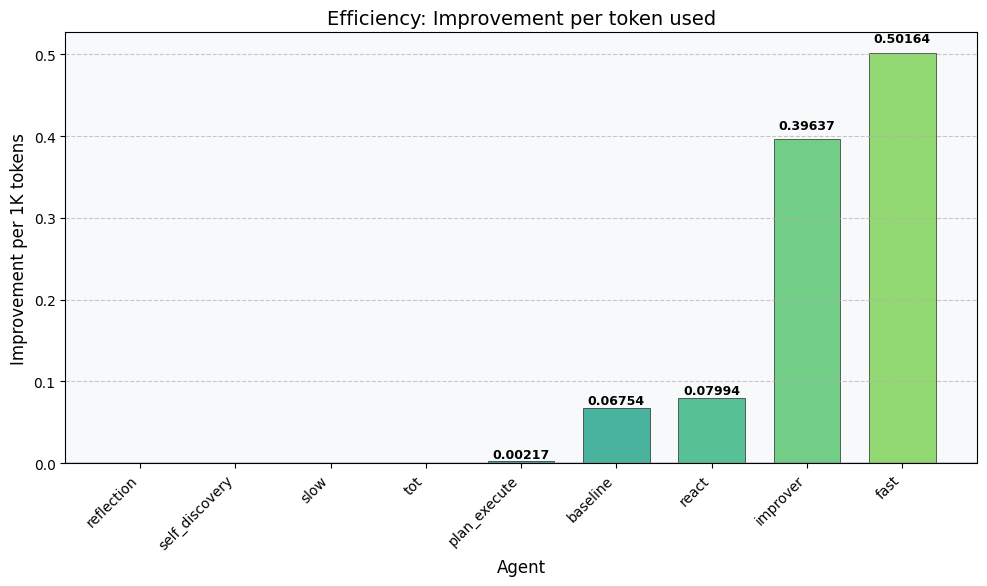

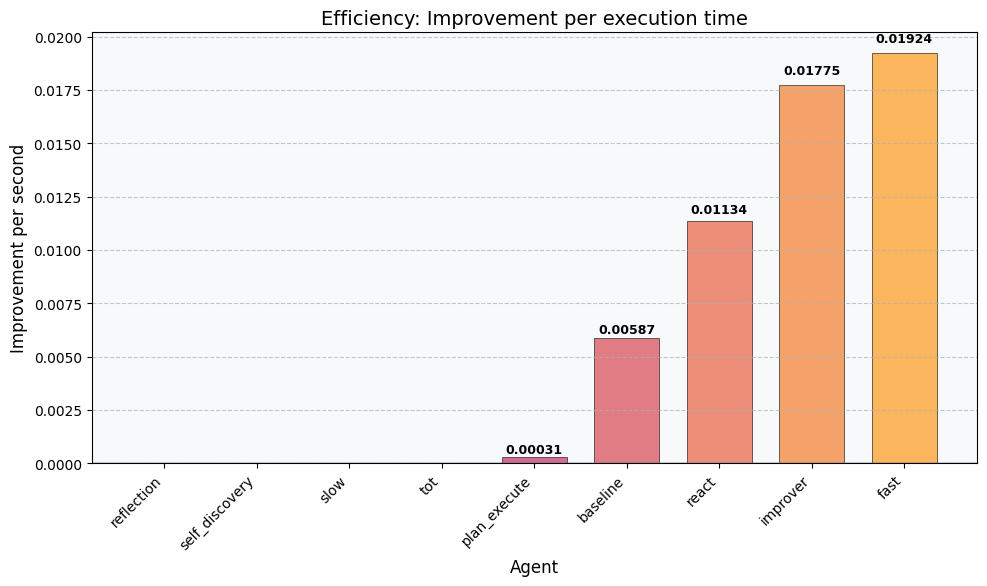

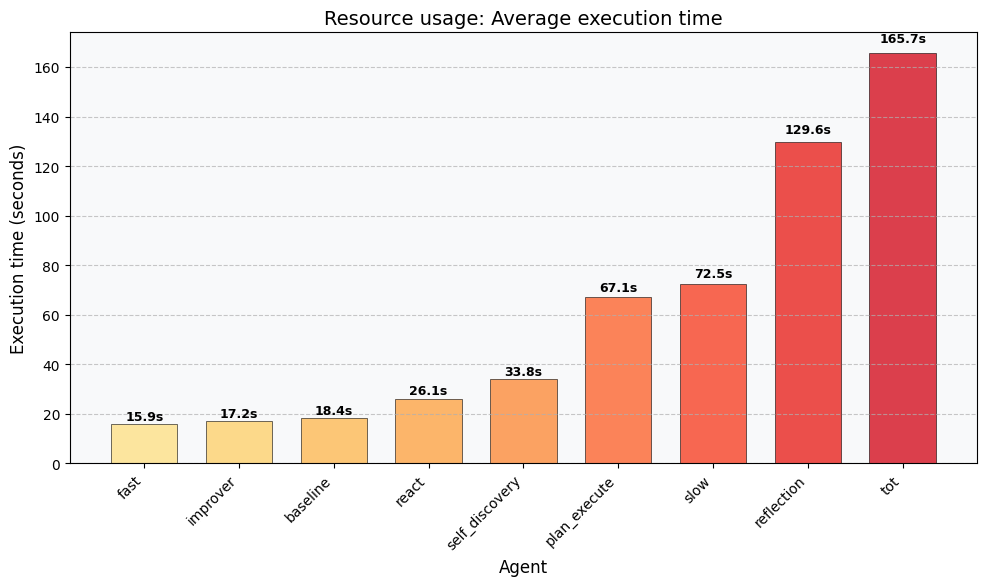

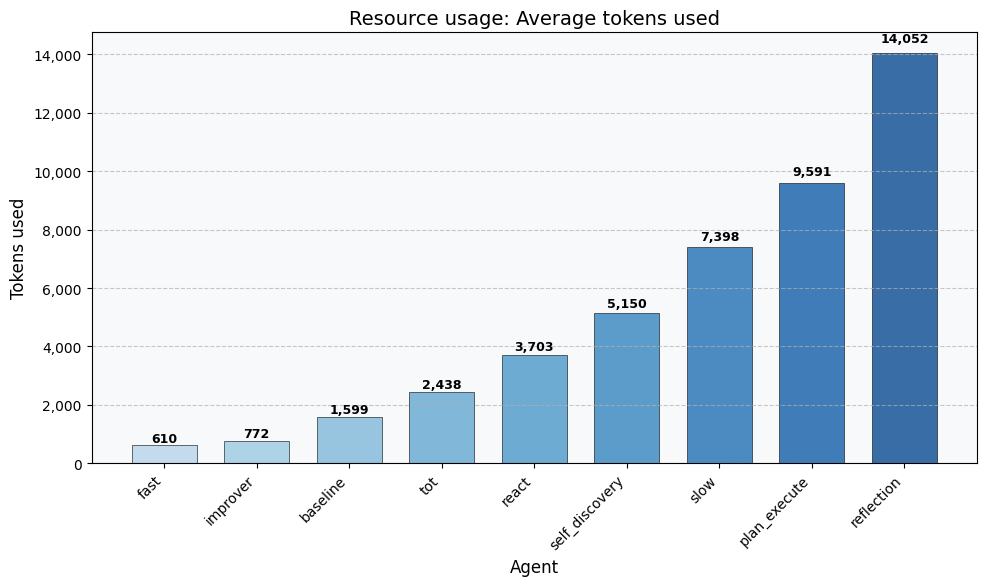

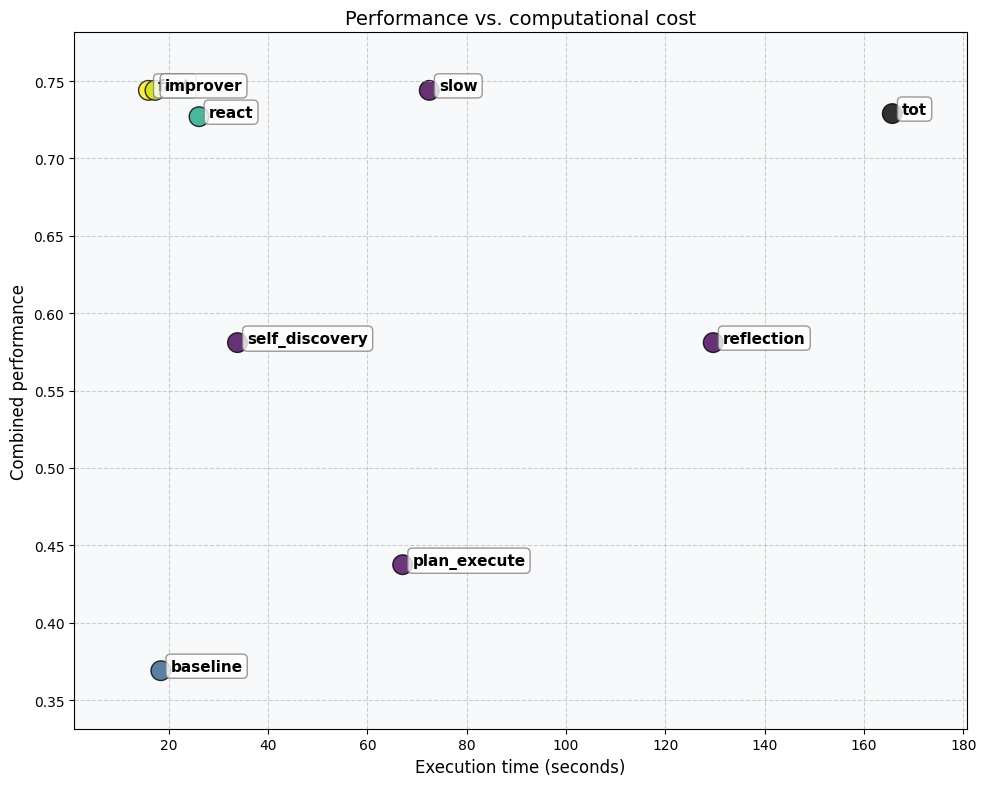


Analysis complete!
Loading and processing results...
Loaded 9 result files.
Found agent names: ['improver' 'plan_execute' 'baseline' 'slow' 'tot' 'fast' 'self_discovery'
 'react' 'reflection']

Aggregating results by agent...

Computing statistical significance...

Saving results to paper_figures-nasa-FD002

Agent names in plots: ['baseline', 'fast', 'improver', 'plan_execute', 'react', 'reflection', 'self_discovery', 'slow', 'tot']

Generating requested plots...


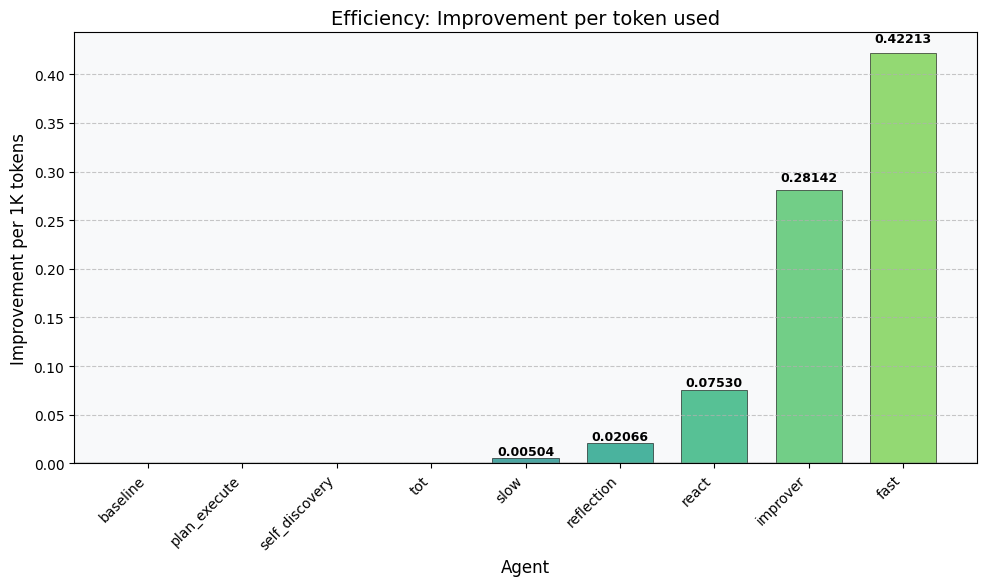

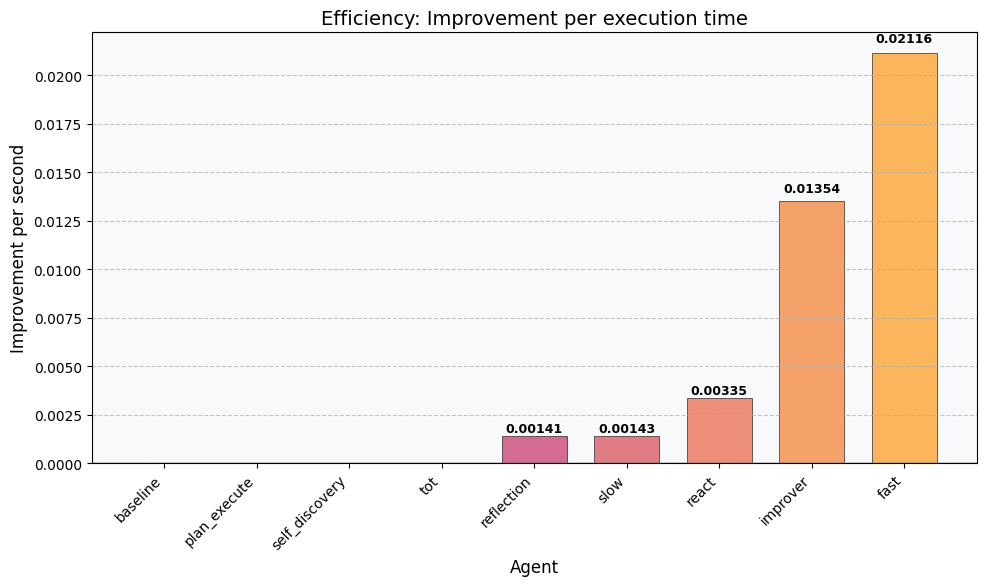

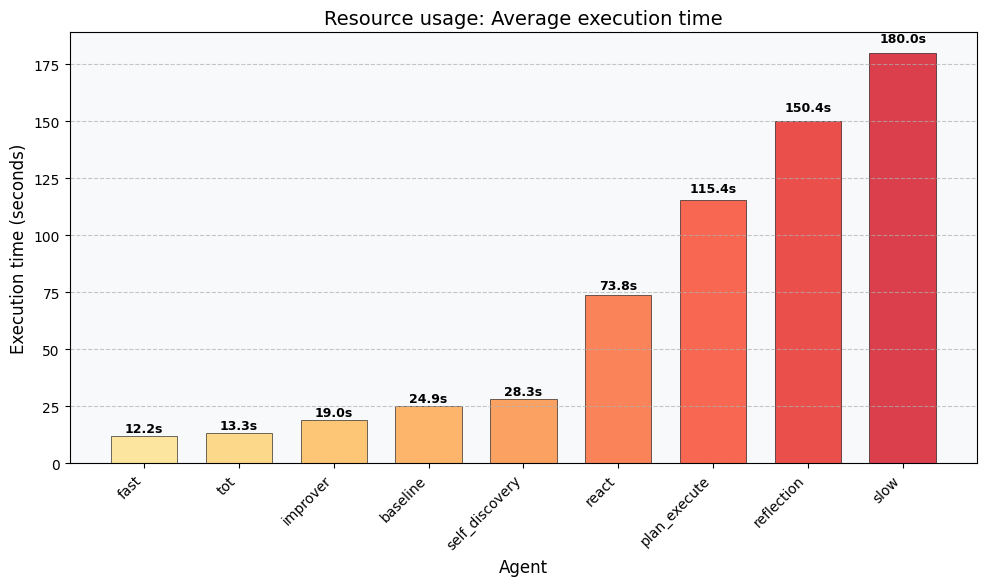

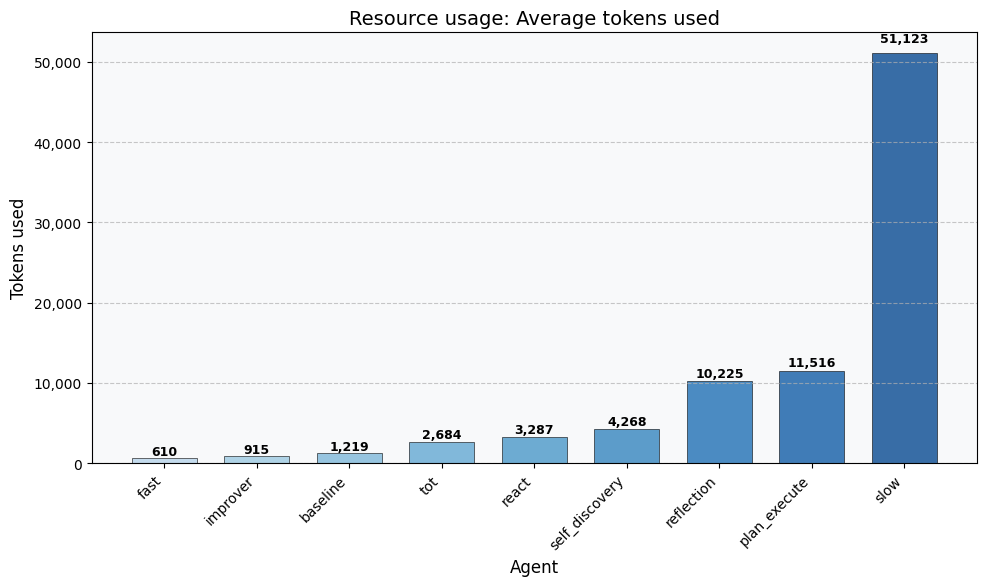

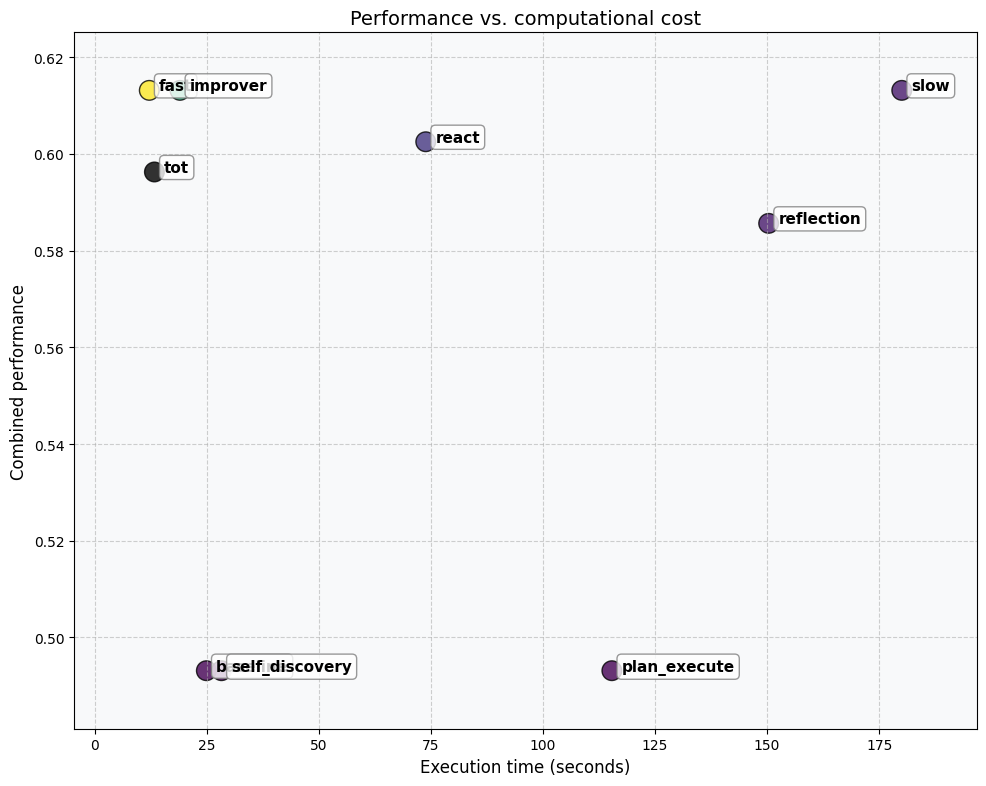


Analysis complete!


agent  total_runs  successful_runs  success_rate  avg_final_new  \
0         baseline           1                1           1.0       0.733333   
1             fast           1                1           1.0       0.833333   
2         improver           1                1           1.0       0.833333   
3     plan_execute           1                1           1.0       0.733333   
4            react           1                1           1.0       0.800000   
5       reflection           1                1           1.0       0.800000   
6   self_discovery           1                1           1.0       0.733333   
7             slow           1                1           1.0       0.833333   
8              tot           1                1           1.0       0.800000   
9         baseline           1                1           1.0       0.566667   
10            fast           1                1           1.0       0.633333   
11        improver           1                1           1.0       0.666667   
12    plan_execute           1                1           1.0       0.633333   
13           react           1                1           1.0       0.633333   
14      reflection           1                1           1.0       0.633333   
15  self_discovery           1                1           1.0       0.633333   
16            slow           1                1           1.0       0.666667   
17             tot           1                1           1.0       0.600000   
18        baseline           1                1           1.0       0.716667   
19            fast           1                1           1.0       0.800000   
20        improver           1                1           1.0       0.883333   
21    plan_execute           1                1           1.0       0.716667   
22           react           1                1           1.0       0.566667   
23      reflection           1                1           1.0       0.716667   
24  self_discovery           1                1           1.0       0.716667   
25            slow           1                1           1.0       0.833333   
26             tot           1                1           1.0       0.800000   
27        baseline           1                1           1.0       0.480000   
28            fast           1                1           1.0       0.678000   
29        improver           1                1           1.0       0.678000   
30    plan_execute           1                1           1.0       0.392857   
31           react           1                1           1.0       0.668000   
32      reflection           1                1           1.0       0.372000   
33  self_discovery           1                1           1.0       0.372000   
34            slow           1                1           1.0       0.678000   
35             tot           1                1           1.0       0.668000   
36        baseline           1                1           1.0       0.265000   
37            fast           1                1           1.0       0.522500   
38        improver           1                1           1.0       0.522500   
39    plan_execute           1                1           1.0       0.265000   
40           react           1                1           1.0       0.512500   
41      reflection           1                1           1.0       0.476250   
42  self_discovery           1                1           1.0       0.265000   
43            slow           1                1           1.0       0.522500   
44             tot           1                1           1.0       0.510000   

    std_final_new  se_final_new  min_final_new  max_final_new  avg_final_old  \
0             NaN           0.0       0.733333       0.733333       0.860000   
1             NaN           0.0       0.833333       0.833333       0.870000   
2             NaN           0.0       0.833333       0.833333       0.893333   
3           

In [22]:
datasets = ['healthcare', 'eligibility', 'financial', 'nasa', 'nasa-FD002']

all_agg_df = {}
for dataset in datasets:
    df, agg_df, sig_df = analyze_results("results", f"paper_figures-{dataset}", dataset)
    # create a new dataframe with a column for the dataset name
    agg_df['dataset'] = dataset
    all_agg_df[dataset] = agg_df  # store each dataset's aggregated Data

# concatenate all aggregated DataFrames
final_agg_df = pd.concat(all_agg_df.values(), ignore_index=True)
final_agg_df


In [26]:
# rename some rows in the column agent, e.g., 'standard' to 'baseline'
final_agg_df['agent'] = final_agg_df['agent'].replace({'baseline': 'Standard'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'improver': 'KC-agent'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'fast': 'KC-fast'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'slow': 'KC-slow'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'react': 'ReAct'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'reflection': 'Reflexion'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'self_discovery': 'Self-Discovery'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'plan_execute': 'Plan-Execute'})
final_agg_df['agent'] = final_agg_df['agent'].replace({'tot': 'ToT'})


final_agg_df

agent  total_runs  successful_runs  success_rate  avg_final_new  \
0         Standard           1                1           1.0       0.733333   
1          KC-fast           1                1           1.0       0.833333   
2         KC-agent           1                1           1.0       0.833333   
3     Plan-Execute           1                1           1.0       0.733333   
4            ReAct           1                1           1.0       0.800000   
5        Reflexion           1                1           1.0       0.800000   
6   Self-Discovery           1                1           1.0       0.733333   
7          KC-slow           1                1           1.0       0.833333   
8              ToT           1                1           1.0       0.800000   
9         Standard           1                1           1.0       0.566667   
10         KC-fast           1                1           1.0       0.633333   
11        KC-agent           1                1           1.0       0.666667   
12    Plan-Execute           1                1           1.0       0.633333   
13           ReAct           1                1           1.0       0.633333   
14       Reflexion           1                1           1.0       0.633333   
15  Self-Discovery           1                1           1.0       0.633333   
16         KC-slow           1                1           1.0       0.666667   
17             ToT           1                1           1.0       0.600000   
18        Standard           1                1           1.0       0.716667   
19         KC-fast           1                1           1.0       0.800000   
20        KC-agent           1                1           1.0       0.883333   
21    Plan-Execute           1                1           1.0       0.716667   
22           ReAct           1                1           1.0       0.566667   
23       Reflexion           1                1           1.0       0.716667   
24  Self-Discovery           1                1           1.0       0.716667   
25         KC-slow           1                1           1.0       0.833333   
26             ToT           1                1           1.0       0.800000   
27        Standard           1                1           1.0       0.480000   
28         KC-fast           1                1           1.0       0.678000   
29        KC-agent           1                1           1.0       0.678000   
30    Plan-Execute           1                1           1.0       0.392857   
31           ReAct           1                1           1.0       0.668000   
32       Reflexion           1                1           1.0       0.372000   
33  Self-Discovery           1                1           1.0       0.372000   
34         KC-slow           1                1           1.0       0.678000   
35             ToT           1                1           1.0       0.668000   
36        Standard           1                1           1.0       0.265000   
37         KC-fast           1                1           1.0       0.522500   
38        KC-agent           1                1           1.0       0.522500   
39    Plan-Execute           1                1           1.0       0.265000   
40           ReAct           1                1           1.0       0.512500   
41       Reflexion           1                1           1.0       0.476250   
42  Self-Discovery           1                1           1.0       0.265000   
43         KC-slow           1                1           1.0       0.522500   
44             ToT           1                1           1.0       0.510000   

    std_final_new  se_final_new  min_final_new  max_final_new  avg_final_old  \
0             NaN           0.0       0.733333       0.733333       0.860000   
1             NaN           0.0       0.833333       0.833333       0.870000   
2             NaN           0.0       0.833333       0.833333       0.893333   
3           

In [ ]:
final_agg_df['dataset'] = final_agg_df['dataset'].replace({'nasa': 'nasa-FD001'})

# save the final aggregated DataFrame
final_agg_df.to_csv("paper_figures/final_aggregated_results.csv", index=False)

# read the final aggregated DataFrame
# final_agg_df = pd.read_csv("paper_figures/final_aggregated_results.csv")
# print(final_agg_df.describe())

🎨 Generating enhanced AAAI paper plots...
📊 1. Creating performance distribution by dataset...


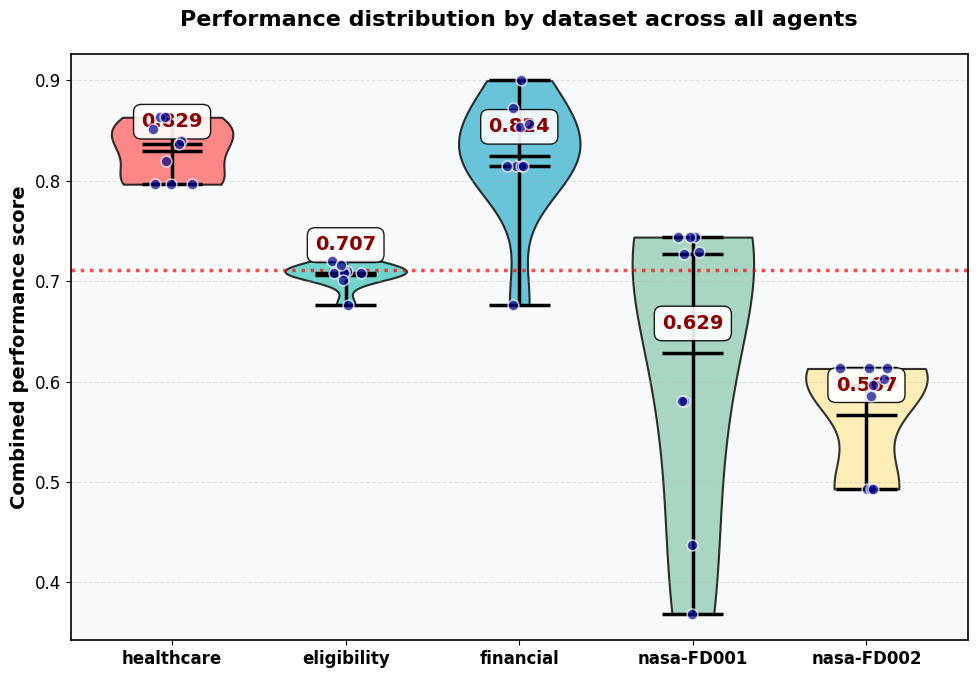

⚡ 2. Creating efficiency trade-off analysis with colored quadrants...


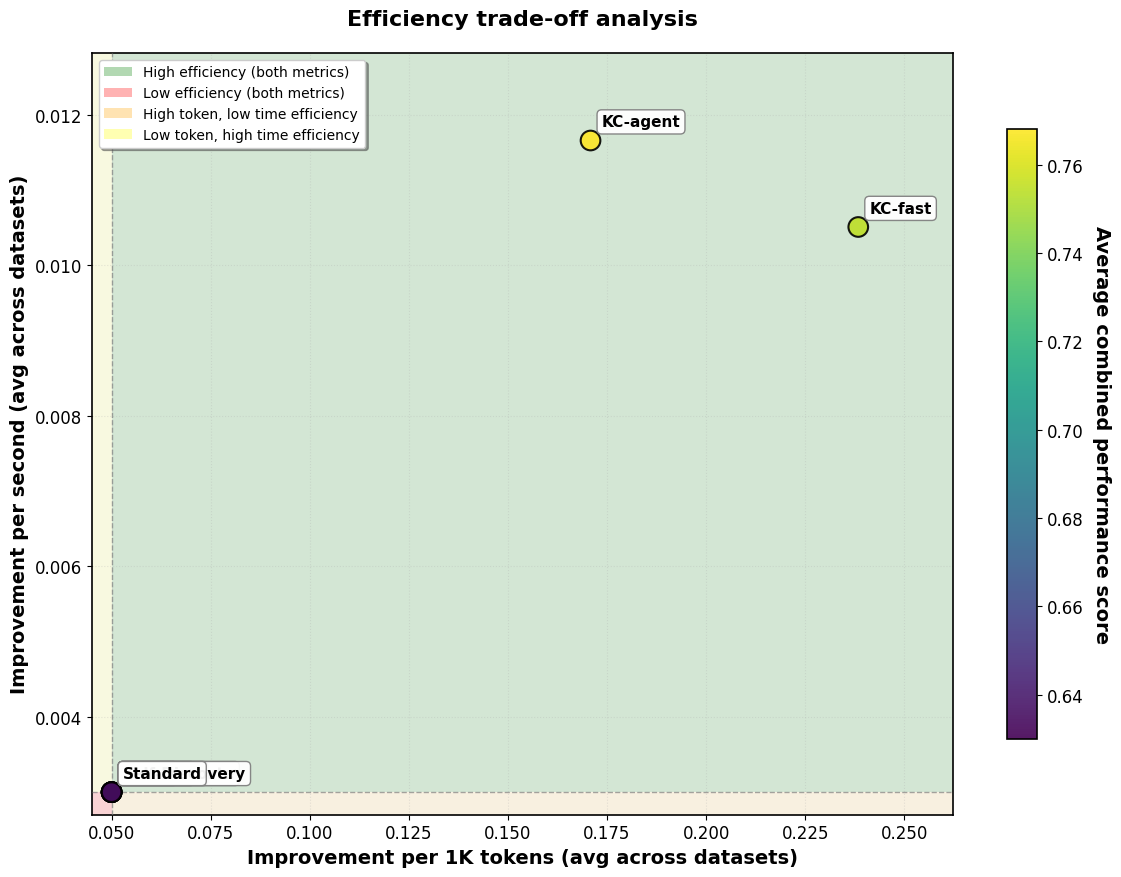

⏱️ 3. Creating performance vs execution time with colored quadrants...


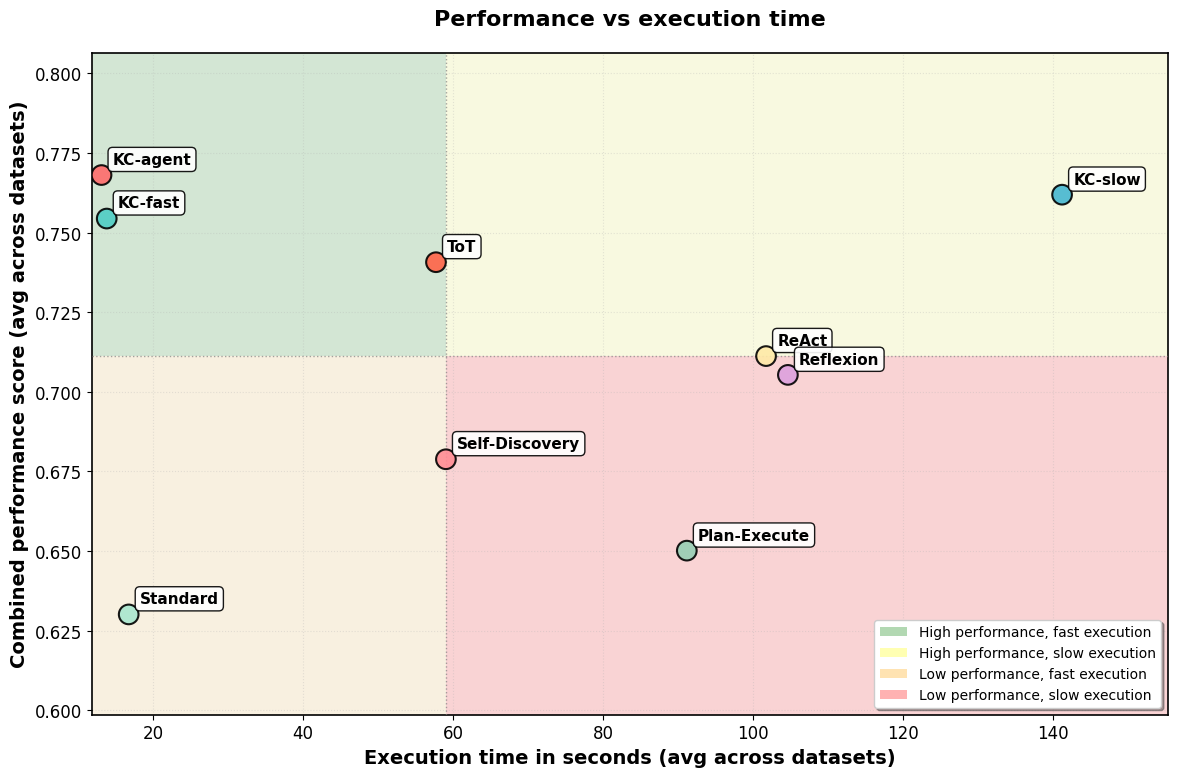

🔢 4. Creating performance vs token usage with colored quadrants...


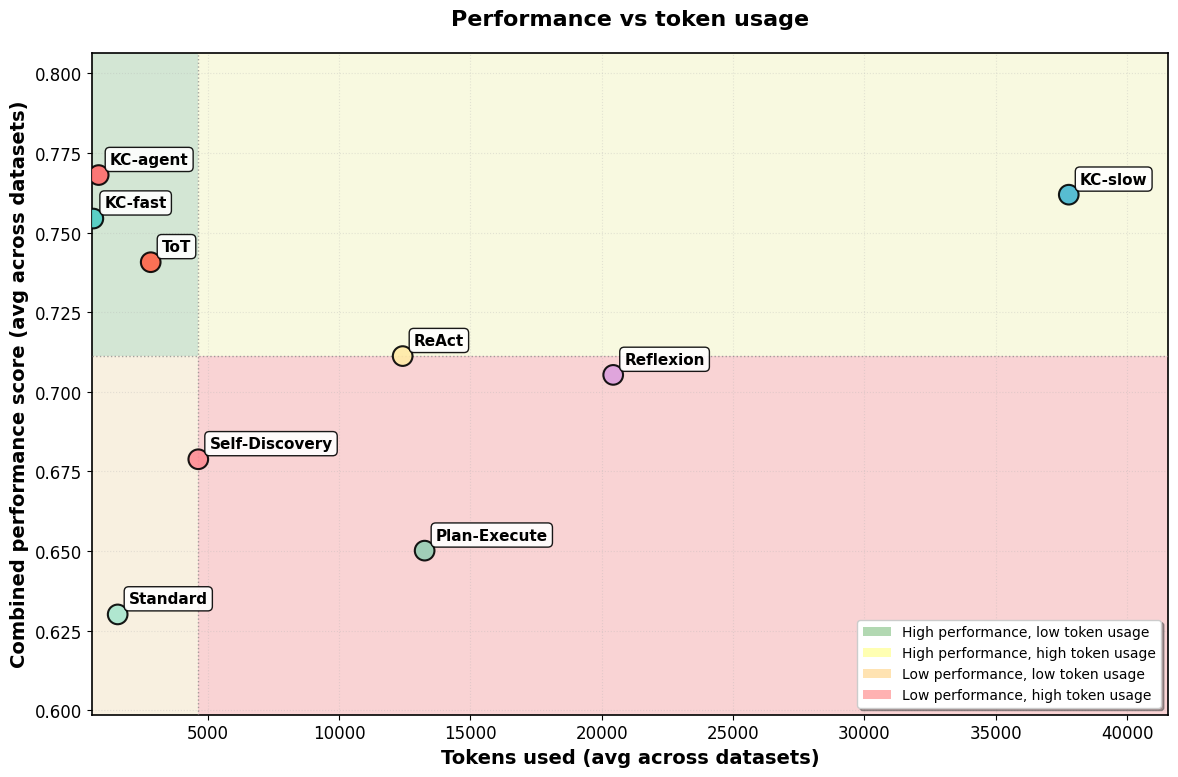

🎯 5. Creating multi-dimensional agent radar with distinct colors...


/tmp/ipykernel_10276/587756989.py:515: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles, values, 'o-', linewidth=linewidth, label=label,


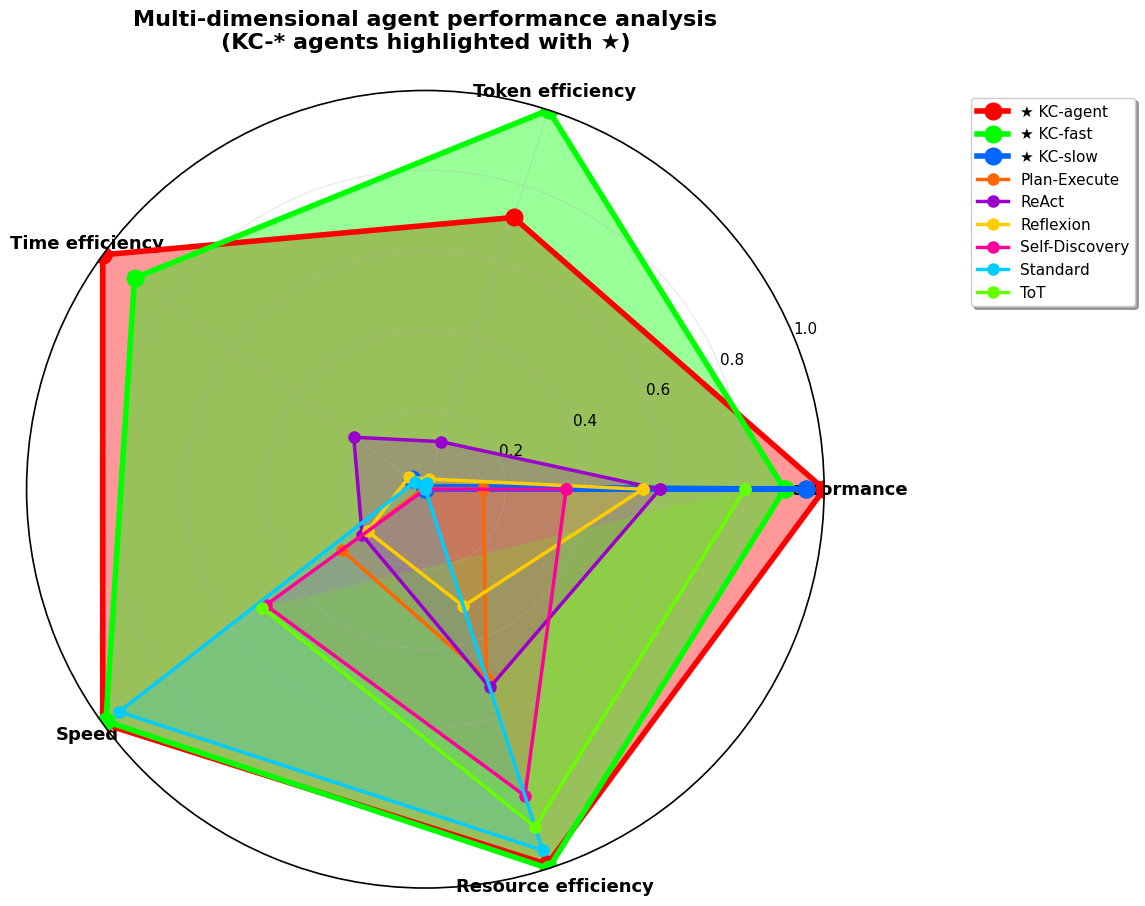

📈 6. Creating performance consistency analysis with colored quadrants...


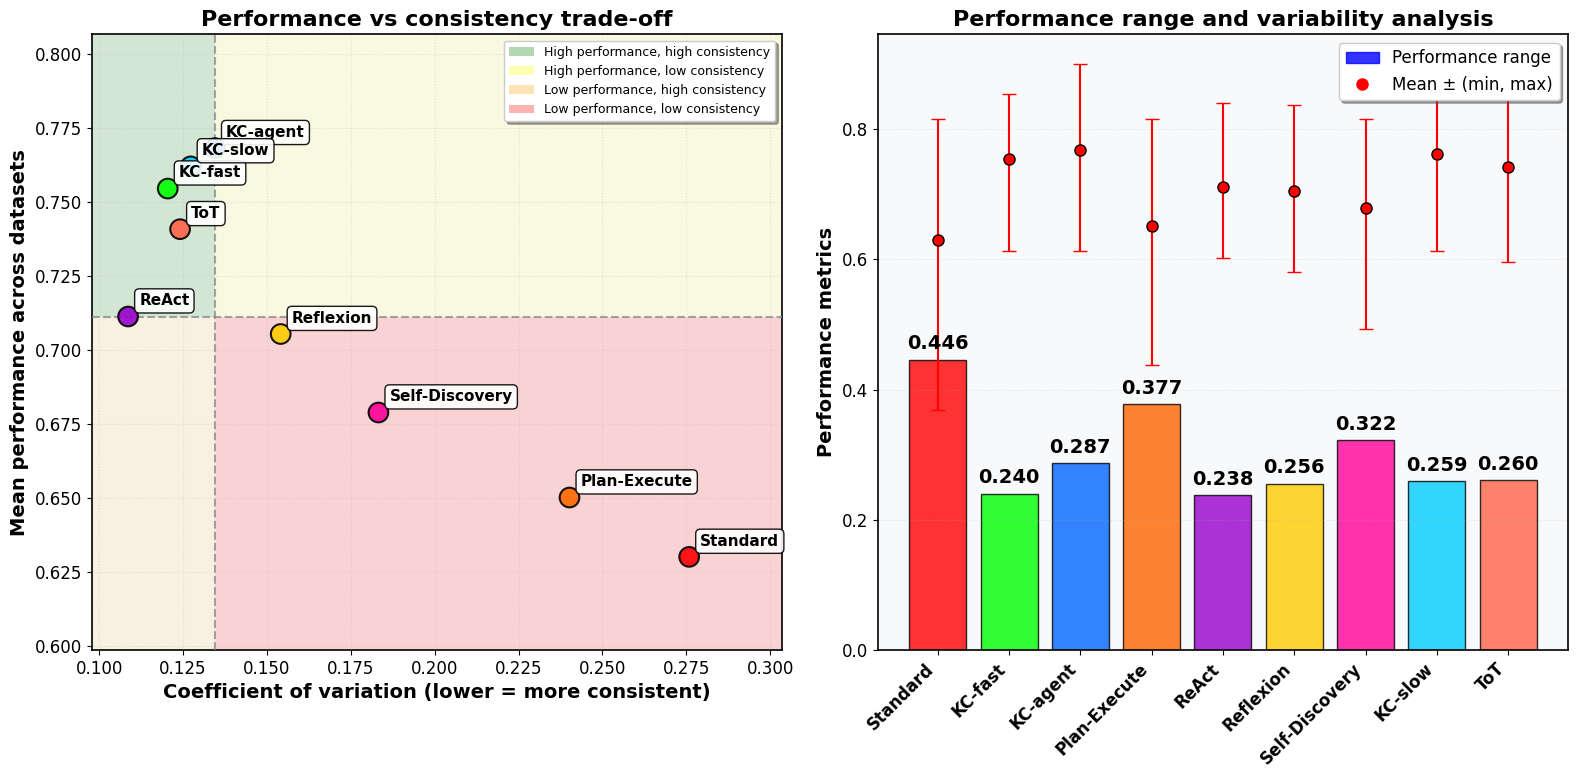

🏆 7. Creating dataset difficulty ranking...


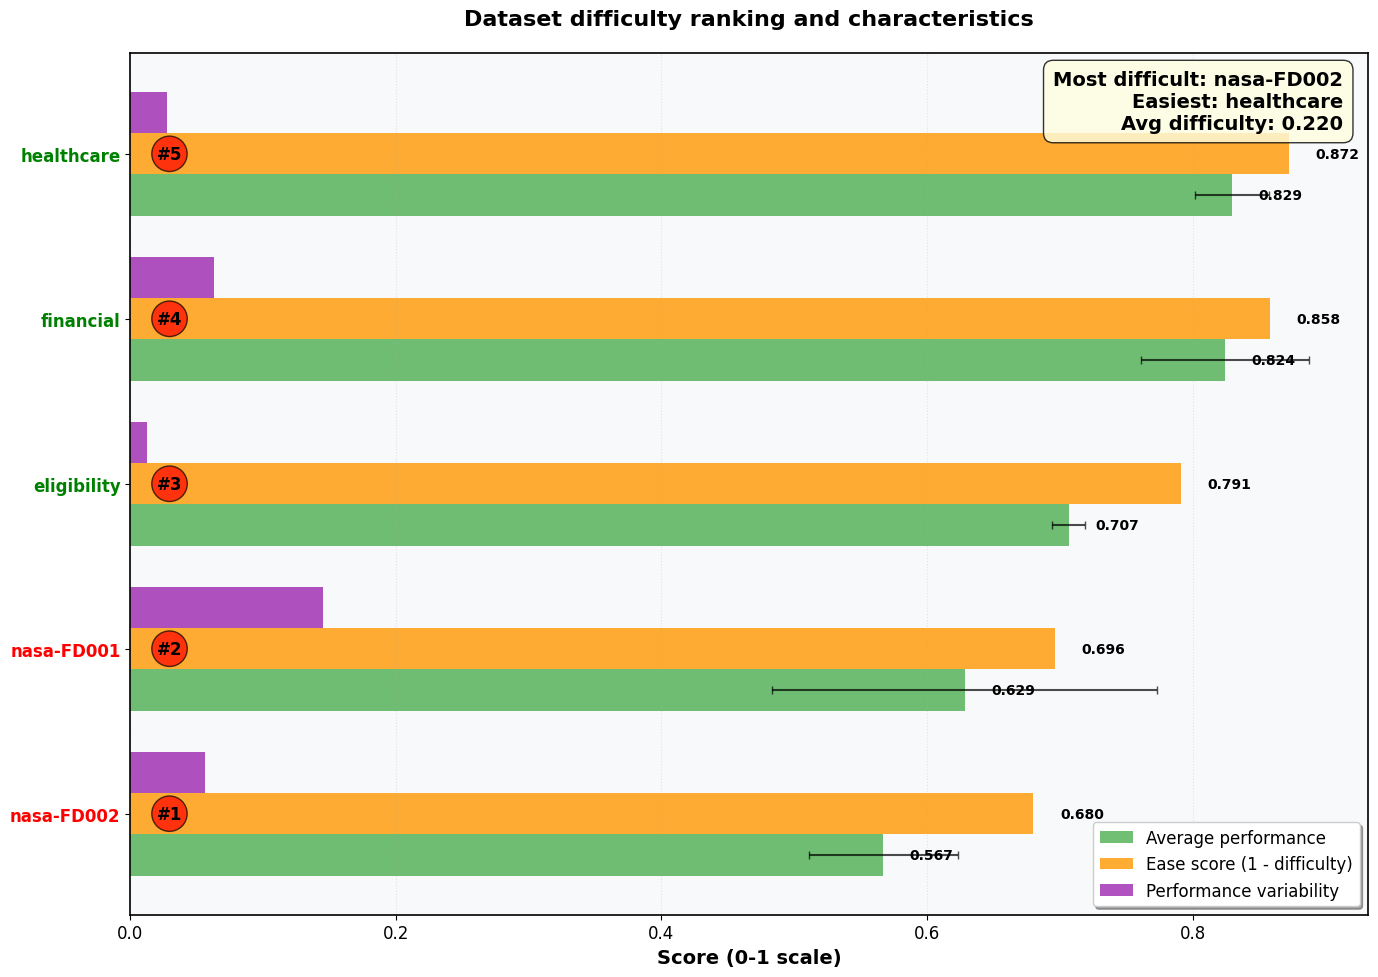

🚀 8. Creating SURPRISE plot: Agent performance evolution analysis...


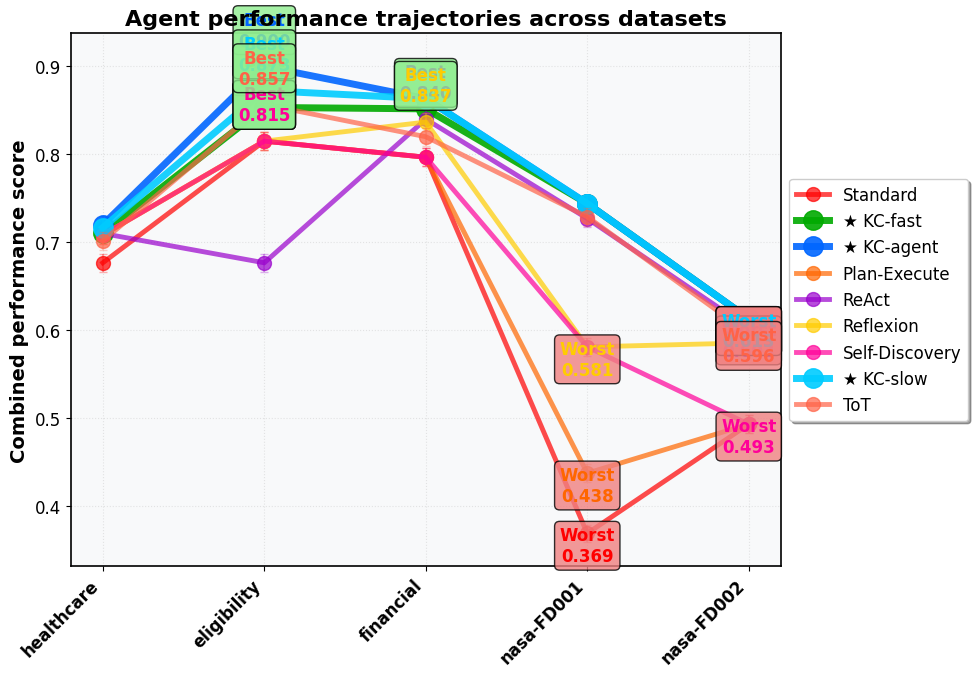

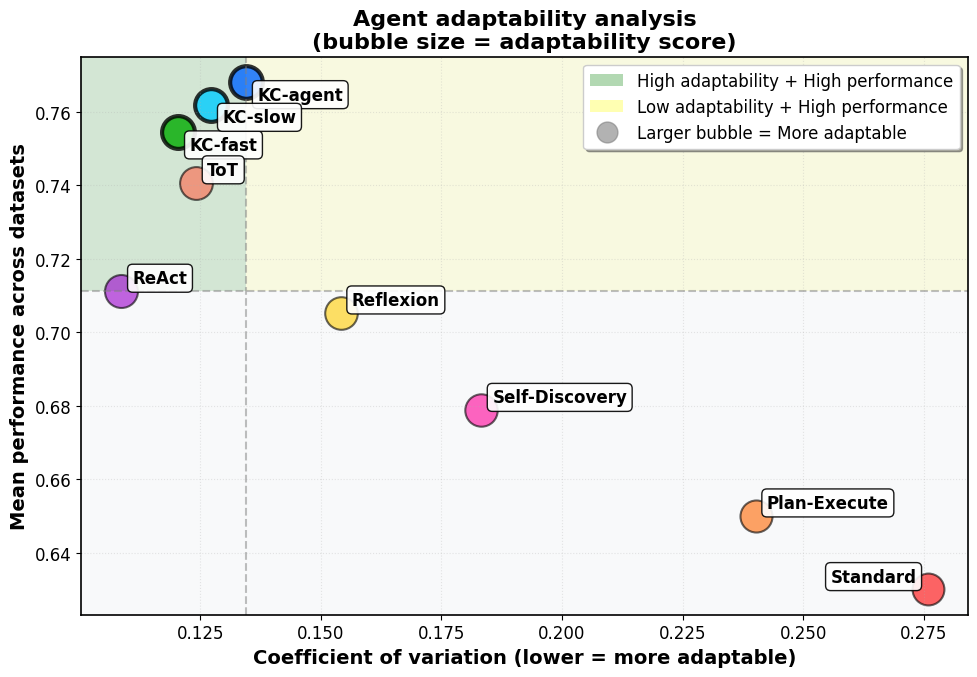

✅ All enhanced plots saved to paper_figures/
🌟 SURPRISE PLOT included: Performance Evolution & Adaptability Analysis!
🚀 Ready for top-tier conference submission!


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle, Circle, Polygon
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.patheffects as path_effects
from matplotlib.collections import LineCollection

# Set publication-ready styling with refined aesthetics
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 16

FIGURE_DPI = 300

def create_performance_distribution_by_dataset(final_agg_df, output_dir="enhanced_figures"):
   """
   Create an enhanced violin plot showing performance distributions by dataset.
   """
   
   # AAAI-compliant font settings
   plt.rcParams.update({
       'font.size': 14,           # Base font size
       'axes.titlesize': 16,      # Title font size
       'axes.labelsize': 14,      # Axis label font size
       'xtick.labelsize': 12,     # X-tick label size
       'ytick.labelsize': 12,     # Y-tick label size
       'legend.fontsize': 12,     # Legend font size
       'figure.titlesize': 18,    # Figure title size
       'font.weight': 'normal',   # Font weight
       'axes.linewidth': 1.2,     # Axis line width
       'grid.linewidth': 0.8,     # Grid line width
   })
   
   fig, ax = plt.subplots(figsize=(10, 7))
   
   datasets = final_agg_df['dataset'].unique()
   performance_by_dataset = []
   dataset_labels = []
   
   for dataset in datasets:
       dataset_data = final_agg_df[final_agg_df['dataset'] == dataset]['avg_final_combined'].dropna()
       if len(dataset_data) > 0:
           performance_by_dataset.append(dataset_data.values)
           dataset_labels.append(dataset)
   
   if performance_by_dataset:
       # Create violin plot with enhanced styling
       violin_parts = ax.violinplot(performance_by_dataset, positions=range(len(dataset_labels)), 
                                  showmeans=True, showmedians=True, widths=0.7)
       
       # Enhanced color scheme and styling
       colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
       for i, (pc, color) in enumerate(zip(violin_parts['bodies'], colors[:len(violin_parts['bodies'])])):
           pc.set_facecolor(color)
           pc.set_alpha(0.8)
           pc.set_edgecolor('black')
           pc.set_linewidth(1.5)  # Increased from 1.2
       
       # Style the statistical lines
       for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
           if partname in violin_parts:
               vp = violin_parts[partname]
               vp.set_edgecolor('black')
               vp.set_linewidth(2.5)  # Increased from 2
       
       # Add individual data points as scatter
       for i, data in enumerate(performance_by_dataset):
           y_jitter = np.random.normal(i, 0.05, len(data))
           ax.scatter(y_jitter, data, alpha=0.7, s=60, color='darkblue',  # Increased from 50
                     edgecolors='white', linewidth=1.2, zorder=10)  # Increased linewidth
       
       # Add mean values as text
       for i, data in enumerate(performance_by_dataset):
           mean_val = np.mean(data)
           ax.text(i, mean_val + 0.02, f'{mean_val:.3f}', 
                  ha='center', va='bottom', fontweight='bold', 
                  fontsize=14, color='darkred',  # Increased from 11
                  bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.9))  # Increased padding
   
   ax.set_xticks(range(len(dataset_labels)))
   ax.set_xticklabels(dataset_labels, fontweight='bold')
   ax.set_ylabel('Combined performance score', fontweight='bold')
   ax.set_title('Performance distribution by dataset across all agents', fontweight='bold', pad=20)
   ax.grid(axis='y', alpha=0.3, linestyle='--')
   ax.set_facecolor('#f8f9fa')
   
   # Add statistical annotation
   overall_mean = np.mean([np.mean(data) for data in performance_by_dataset])
   ax.axhline(y=overall_mean, color='red', linestyle=':', linewidth=2.5, alpha=0.7)  # Increased linewidth
#    ax.text(0.02, 0.98, f'Overall mean: {overall_mean:.3f}', 
#           transform=ax.transAxes, va='top', fontweight='bold',
#           fontsize=14,  # Added explicit fontsize
#           bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.9))  # Increased padding and alpha
   
   plt.tight_layout()
   plt.savefig(f"{output_dir}/performance_distribution_by_dataset.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
   plt.show()

def create_efficiency_tradeoff_plot(final_agg_df, output_dir="enhanced_figures"):
    """
    Create efficiency trade-off plot with colored quadrants and improved legends.
    """
    fig, ax = plt.subplots(figsize=(12, 9))
    
    # Aggregate by agent across all datasets
    efficiency_data = final_agg_df.groupby('agent').agg({
        'improvement_per_token': 'mean',
        'improvement_per_second': 'mean',
        'avg_final_combined': 'mean'
    }).reset_index().dropna()
    
    if len(efficiency_data) == 0:
        print("No efficiency data available for plotting")
        return
    
    # Apply minimum thresholds to avoid crowding at origin
    min_token_eff = 0.05
    min_time_eff = 0.003
    
    efficiency_data['improvement_per_token'] = efficiency_data['improvement_per_token'].apply(
        lambda x: max(x, min_token_eff) if x >= 0 else x)
    efficiency_data['improvement_per_second'] = efficiency_data['improvement_per_second'].apply(
        lambda x: max(x, min_time_eff) if x >= 0 else x)
    
    # Calculate quadrant boundaries
    x_median = efficiency_data['improvement_per_token'].median()
    y_median = efficiency_data['improvement_per_second'].median()
    
    # Add colored quadrant backgrounds
    xlim = ax.get_xlim() if ax.get_xlim() != (0.0, 1.0) else (efficiency_data['improvement_per_token'].min() * 0.9, 
                                                              efficiency_data['improvement_per_token'].max() * 1.1)
    ylim = ax.get_ylim() if ax.get_ylim() != (0.0, 1.0) else (efficiency_data['improvement_per_second'].min() * 0.9, 
                                                              efficiency_data['improvement_per_second'].max() * 1.1)
    
    # Set proper limits first
    ax.set_xlim(efficiency_data['improvement_per_token'].min() * 0.9, 
                efficiency_data['improvement_per_token'].max() * 1.1)
    ax.set_ylim(efficiency_data['improvement_per_second'].min() * 0.9, 
                efficiency_data['improvement_per_second'].max() * 1.1)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Add quadrant backgrounds
    # High efficiency (top-right)
    high_eff = Rectangle((x_median, y_median), xlim[1] - x_median, ylim[1] - y_median, 
                        alpha=0.15, facecolor='green', zorder=0)
    ax.add_patch(high_eff)
    
    # Low efficiency (bottom-left)
    low_eff = Rectangle((xlim[0], ylim[0]), x_median - xlim[0], y_median - ylim[0], 
                       alpha=0.15, facecolor='red', zorder=0)
    ax.add_patch(low_eff)
    
    # Mixed efficiency quadrants
    mixed1 = Rectangle((x_median, ylim[0]), xlim[1] - x_median, y_median - ylim[0], 
                      alpha=0.10, facecolor='orange', zorder=0)
    ax.add_patch(mixed1)
    
    mixed2 = Rectangle((xlim[0], y_median), x_median - xlim[0], ylim[1] - y_median, 
                      alpha=0.10, facecolor='yellow', zorder=0)
    ax.add_patch(mixed2)
    
    # Create color mapping based on combined performance
    performance_norm = plt.Normalize(efficiency_data['avg_final_combined'].min(), 
                                   efficiency_data['avg_final_combined'].max())
    
    # Create scatter plot
    scatter = ax.scatter(efficiency_data['improvement_per_token'], 
                        efficiency_data['improvement_per_second'],
                        s=200, alpha=0.9, 
                        c=efficiency_data['avg_final_combined'],
                        cmap='viridis', edgecolors='black', linewidth=1.5, zorder=5)
    
    # Enhanced label positioning to avoid overlap
    for _, row in efficiency_data.iterrows():
        ax.annotate(row['agent'], 
                   (row['improvement_per_token'], row['improvement_per_second']),
                   xytext=(8, 8), textcoords='offset points', 
                   fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", 
                            edgecolor="gray", alpha=0.95),
                   ha='left', va='bottom', zorder=6)
    
    # Add median lines
    ax.axvline(x=x_median, color='gray', linestyle='--', alpha=0.7, linewidth=1, zorder=3)
    ax.axhline(y=y_median, color='gray', linestyle='--', alpha=0.7, linewidth=1, zorder=3)
    
    # Styling
    ax.set_xlabel('Improvement per 1K tokens (avg across datasets)', fontweight='bold')
    ax.set_ylabel('Improvement per second (avg across datasets)', fontweight='bold')
    ax.set_title('Efficiency trade-off analysis', fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.set_facecolor('#f8f9fa')
    
    # Add colorbar for performance
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
    cbar.set_label('Average combined performance score', rotation=270, labelpad=20, fontweight='bold')
    
    # Create custom legend for quadrants
    legend_elements = [
        mpatches.Patch(facecolor='green', alpha=0.3, label='High efficiency (both metrics)'),
        mpatches.Patch(facecolor='red', alpha=0.3, label='Low efficiency (both metrics)'),
        mpatches.Patch(facecolor='orange', alpha=0.3, label='High token, low time efficiency'),
        mpatches.Patch(facecolor='yellow', alpha=0.3, label='Low token, high time efficiency')
    ]
    
    ax.legend(handles=legend_elements, loc='upper left', frameon=True, 
             fancybox=True, shadow=True, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/efficiency_tradeoff_analysis.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()

def create_performance_vs_execution_time(final_agg_df, output_dir="enhanced_figures"):
    """
    Create performance vs execution time plot with colored quadrants.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Aggregate by agent across all datasets
    perf_time_data = final_agg_df.groupby('agent').agg({
        'avg_final_combined': 'mean',
        'avg_exec_time': 'mean'
    }).reset_index().dropna()
    
    if len(perf_time_data) < 2:
        print("Not enough valid data for performance vs execution time plot")
        return
    
    # Calculate medians for quadrant boundaries
    time_median = perf_time_data['avg_exec_time'].median()
    perf_median = perf_time_data['avg_final_combined'].median()
    
    # Set plot limits
    ax.set_xlim(perf_time_data['avg_exec_time'].min() * 0.9, 
                perf_time_data['avg_exec_time'].max() * 1.1)
    ax.set_ylim(perf_time_data['avg_final_combined'].min() * 0.95, 
                perf_time_data['avg_final_combined'].max() * 1.05)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Add quadrant backgrounds
    # High performance, fast execution (top-left) - BEST
    best = Rectangle((xlim[0], perf_median), time_median - xlim[0], ylim[1] - perf_median, 
                    alpha=0.15, facecolor='green', zorder=0)
    ax.add_patch(best)
    
    # High performance, slow execution (top-right)
    good = Rectangle((time_median, perf_median), xlim[1] - time_median, ylim[1] - perf_median, 
                    alpha=0.10, facecolor='yellow', zorder=0)
    ax.add_patch(good)
    
    # Low performance, fast execution (bottom-left)
    okay = Rectangle((xlim[0], ylim[0]), time_median - xlim[0], perf_median - ylim[0], 
                    alpha=0.10, facecolor='orange', zorder=0)
    ax.add_patch(okay)
    
    # Low performance, slow execution (bottom-right) - WORST
    worst = Rectangle((time_median, ylim[0]), xlim[1] - time_median, perf_median - ylim[0], 
                     alpha=0.15, facecolor='red', zorder=0)
    ax.add_patch(worst)
    
    # Create scatter plot with distinct colors
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#FF8C94', '#A8E6CF', '#FF6347', '#32CD32']
    
    scatter = ax.scatter(perf_time_data['avg_exec_time'], perf_time_data['avg_final_combined'],
                        s=200, alpha=0.9, c=colors[:len(perf_time_data)], 
                        edgecolors='black', linewidth=1.5, zorder=5)
    
    # Add agent labels
    for i, (_, row) in enumerate(perf_time_data.iterrows()):
        ax.annotate(row['agent'], 
                   (row['avg_exec_time'], row['avg_final_combined']),
                   xytext=(8, 8), textcoords='offset points',
                   fontsize=11, fontweight='bold', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
                   zorder=6)
    
    # Add trend line
    if len(perf_time_data) > 1:
        z = np.polyfit(perf_time_data['avg_exec_time'], perf_time_data['avg_final_combined'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(perf_time_data['avg_exec_time'].min(), 
                             perf_time_data['avg_exec_time'].max(), 100)
        # ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, zorder=4)
        
        # Calculate correlation
        corr, p_val = pearsonr(perf_time_data['avg_exec_time'], perf_time_data['avg_final_combined'])
        # ax.text(0.05, 0.95, f'Correlation: {corr:.3f}\n(p-value: {p_val:.3f})', 
        #        transform=ax.transAxes, va='top', fontweight='bold',
        #        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
    
    # Add median lines
    ax.axvline(x=time_median, color='gray', linestyle=':', alpha=0.7, linewidth=1, zorder=3)
    ax.axhline(y=perf_median, color='gray', linestyle=':', alpha=0.7, linewidth=1, zorder=3)
    
    ax.set_xlabel('Execution time in seconds (avg across datasets)', fontweight='bold')
    ax.set_ylabel('Combined performance score (avg across datasets)', fontweight='bold')
    ax.set_title('Performance vs execution time', fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.set_facecolor('#f8f9fa')
    
    # Create custom legend for quadrants
    legend_elements = [
        mpatches.Patch(facecolor='green', alpha=0.3, label='High performance, fast execution'),
        mpatches.Patch(facecolor='yellow', alpha=0.3, label='High performance, slow execution'),
        mpatches.Patch(facecolor='orange', alpha=0.3, label='Low performance, fast execution'),
        mpatches.Patch(facecolor='red', alpha=0.3, label='Low performance, slow execution'),
        # Line2D([0], [0], color='red', linestyle='--', label='Trend line')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
             fancybox=True, shadow=True, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/performance_vs_execution_time.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()

def create_performance_vs_token_usage(final_agg_df, output_dir="enhanced_figures"):
    """
    Create performance vs token usage plot with colored quadrants.
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Aggregate by agent across all datasets
    perf_token_data = final_agg_df.groupby('agent').agg({
        'avg_final_combined': 'mean',
        'avg_tokens_used': 'mean'
    }).reset_index().dropna()
    
    if len(perf_token_data) < 2:
        print("Not enough valid data for performance vs token usage plot")
        return
    
    # Calculate medians for quadrant boundaries
    token_median = perf_token_data['avg_tokens_used'].median()
    perf_median = perf_token_data['avg_final_combined'].median()
    
    # Set plot limits
    ax.set_xlim(perf_token_data['avg_tokens_used'].min() * 0.9, 
                perf_token_data['avg_tokens_used'].max() * 1.1)
    ax.set_ylim(perf_token_data['avg_final_combined'].min() * 0.95, 
                perf_token_data['avg_final_combined'].max() * 1.05)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Add quadrant backgrounds
    # High performance, low token usage (top-left) - BEST
    best = Rectangle((xlim[0], perf_median), token_median - xlim[0], ylim[1] - perf_median, 
                    alpha=0.15, facecolor='green', zorder=0)
    ax.add_patch(best)
    
    # High performance, high token usage (top-right)
    good = Rectangle((token_median, perf_median), xlim[1] - token_median, ylim[1] - perf_median, 
                    alpha=0.10, facecolor='yellow', zorder=0)
    ax.add_patch(good)
    
    # Low performance, low token usage (bottom-left)
    okay = Rectangle((xlim[0], ylim[0]), token_median - xlim[0], perf_median - ylim[0], 
                    alpha=0.10, facecolor='orange', zorder=0)
    ax.add_patch(okay)
    
    # Low performance, high token usage (bottom-right) - WORST
    worst = Rectangle((token_median, ylim[0]), xlim[1] - token_median, perf_median - ylim[0], 
                     alpha=0.15, facecolor='red', zorder=0)
    ax.add_patch(worst)
    
    # Create scatter plot with distinct colors
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#FF8C94', '#A8E6CF', '#FF6347', '#32CD32']
    
    scatter = ax.scatter(perf_token_data['avg_tokens_used'], perf_token_data['avg_final_combined'],
                        s=200, alpha=0.9, c=colors[:len(perf_token_data)], 
                        edgecolors='black', linewidth=1.5, zorder=5)
    
    # Add agent labels
    for i, (_, row) in enumerate(perf_token_data.iterrows()):
        ax.annotate(row['agent'], 
                   (row['avg_tokens_used'], row['avg_final_combined']),
                   xytext=(8, 8), textcoords='offset points',
                   fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
                   zorder=6)
    
    # Add trend line
    if len(perf_token_data) > 1:
        z = np.polyfit(perf_token_data['avg_tokens_used'], perf_token_data['avg_final_combined'], 1)
        p = np.poly1d(z)
        x_trend = np.linspace(perf_token_data['avg_tokens_used'].min(), 
                             perf_token_data['avg_tokens_used'].max(), 100)
        # ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, zorder=4)
        
        # Calculate correlation
        corr, p_val = pearsonr(perf_token_data['avg_tokens_used'], perf_token_data['avg_final_combined'])
        # ax.text(0.05, 0.95, f'Correlation: {corr:.3f}\n(p-value: {p_val:.3f})', 
        #        transform=ax.transAxes, va='top', fontweight='bold',
        #        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow", alpha=0.8))
    
    # Add median lines
    ax.axvline(x=token_median, color='gray', linestyle=':', alpha=0.7, linewidth=1, zorder=3)
    ax.axhline(y=perf_median, color='gray', linestyle=':', alpha=0.7, linewidth=1, zorder=3)
    
    ax.set_xlabel('Tokens used (avg across datasets)', fontweight='bold')
    ax.set_ylabel('Combined performance score (avg across datasets)', fontweight='bold')
    ax.set_title('Performance vs token usage', fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, linestyle=':')
    ax.set_facecolor('#f8f9fa')
    
    # Create custom legend for quadrants
    legend_elements = [
        mpatches.Patch(facecolor='green', alpha=0.3, label='High performance, low token usage'),
        mpatches.Patch(facecolor='yellow', alpha=0.3, label='High performance, high token usage'),
        mpatches.Patch(facecolor='orange', alpha=0.3, label='Low performance, low token usage'),
        mpatches.Patch(facecolor='red', alpha=0.3, label='Low performance, high token usage'),
        # Line2D([0], [0], color='red', linestyle='--', label='Trend line')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', frameon=True, 
             fancybox=True, shadow=True, fontsize=10)
    
    # Format x-axis with proper scaling
    ax.ticklabel_format(style='plain', axis='x')
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/performance_vs_token_usage.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()

def create_agent_performance_radar(final_agg_df, output_dir="enhanced_figures"):
    """
    Create a radar chart with distinct colors, highlighting KC-* agents.
    """
    # Aggregate by agent across all datasets
    agent_metrics = final_agg_df.groupby('agent').agg({
        'avg_final_combined': 'mean',
        'avg_exec_time': 'mean',
        'avg_tokens_used': 'mean',
        'improvement_per_token': 'mean',
        'improvement_per_second': 'mean'
    }).reset_index()
    
    # Normalize metrics to 0-1 scale (higher is better for all)
    # Invert time and token metrics (lower is better)
    agent_metrics['speed_score'] = 1 / (1 + agent_metrics['avg_exec_time'] / agent_metrics['avg_exec_time'].max())
    agent_metrics['efficiency_score'] = 1 / (1 + agent_metrics['avg_tokens_used'] / agent_metrics['avg_tokens_used'].max())
    
    final_metrics = ['avg_final_combined', 'improvement_per_token', 
                    'improvement_per_second', 'speed_score', 'efficiency_score']
    metric_labels = ['Performance', 'Token efficiency', 'Time efficiency', 'Speed', 'Resource efficiency']
    
    # Normalize all metrics to 0-1
    for metric in final_metrics:
        if metric in agent_metrics.columns:
            agent_metrics[metric] = (agent_metrics[metric] - agent_metrics[metric].min()) / \
                                   (agent_metrics[metric].max() - agent_metrics[metric].min())
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    # Number of metrics
    N = len(final_metrics)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Distinct colors with KC-* agents highlighted
    distinct_colors = [
        '#FF0000',  # Bright Red
        '#00FF00',  # Bright Green  
        '#0066FF',  # Bright Blue
        '#FF6600',  # Orange
        '#9900CC',  # Purple
        '#FFCC00',  # Gold
        '#FF0099',  # Hot Pink
        '#00CCFF',  # Cyan
        '#66FF00',  # Lime
        '#FF3366'   # Rose
    ]
    
    # Plot each agent
    for i, (_, agent_row) in enumerate(agent_metrics.iterrows()):
        agent_name = agent_row['agent']
        values = [agent_row[metric] for metric in final_metrics]
        values += values[:1]  # Complete the circle
        
        # Special highlighting for KC-* agents
        if 'kc' in agent_name.lower() or agent_name.startswith('KC'):
            color = distinct_colors[i % len(distinct_colors)]
            linewidth = 4
            markersize = 12
            alpha_fill = 0.4
            linestyle = '-'
            label = f"★ {agent_name}"  # Star prefix for KC agents
        else:
            color = distinct_colors[i % len(distinct_colors)]
            linewidth = 2.5
            markersize = 8
            alpha_fill = 0.2
            linestyle = '-'
            label = agent_name
        
        ax.plot(angles, values, 'o-', linewidth=linewidth, label=label,
               color=color, markersize=markersize, linestyle=linestyle)
        ax.fill(angles, values, alpha=alpha_fill, color=color)
    
    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, fontweight='bold', fontsize=13)
    
    # Add grid and styling
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add title and legend
    ax.set_title('Multi-dimensional agent performance analysis\n(KC-* agents highlighted with ★)', 
                fontweight='bold', pad=30, fontsize=16)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), frameon=True, 
              fancybox=True, shadow=True, fontsize=11)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/agent_performance_radar.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()

def create_performance_consistency_analysis(final_agg_df, output_dir="enhanced_figures"):
    """
    Create performance consistency analysis with colored quadrants.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Calculate consistency metrics for each agent
    consistency_data = []
    for agent in final_agg_df['agent'].unique():
        agent_data = final_agg_df[final_agg_df['agent'] == agent]
        if len(agent_data) > 1:  # Need multiple datasets for consistency analysis
            performances = agent_data['avg_final_combined'].values
            consistency_data.append({
                'agent': agent,
                'mean_performance': np.mean(performances),
                'std_performance': np.std(performances),
                'cv_performance': np.std(performances) / np.mean(performances),  # Coefficient of variation
                'min_performance': np.min(performances),
                'max_performance': np.max(performances),
                'range_performance': np.max(performances) - np.min(performances),
                'datasets_count': len(agent_data)
            })
    
    if not consistency_data:
        print("Not enough data for consistency analysis")
        return
    
    consistency_df = pd.DataFrame(consistency_data)
    
    # Plot 1: Mean Performance vs Consistency with colored quadrants
    cv_median = consistency_df['cv_performance'].median()
    perf_median = consistency_df['mean_performance'].median()
    
    # Set plot limits
    ax1.set_xlim(consistency_df['cv_performance'].min() * 0.9, 
                 consistency_df['cv_performance'].max() * 1.1)
    ax1.set_ylim(consistency_df['mean_performance'].min() * 0.95, 
                 consistency_df['mean_performance'].max() * 1.05)
    
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    
    # Add quadrant backgrounds
    # High performance, high consistency (low CV) - top-left - BEST
    best = Rectangle((xlim[0], perf_median), cv_median - xlim[0], ylim[1] - perf_median, 
                    alpha=0.15, facecolor='green', zorder=0)
    ax1.add_patch(best)
    
    # High performance, low consistency (high CV) - top-right
    good = Rectangle((cv_median, perf_median), xlim[1] - cv_median, ylim[1] - perf_median, 
                    alpha=0.10, facecolor='yellow', zorder=0)
    ax1.add_patch(good)
    
    # Low performance, high consistency - bottom-left
    okay = Rectangle((xlim[0], ylim[0]), cv_median - xlim[0], perf_median - ylim[0], 
                    alpha=0.10, facecolor='orange', zorder=0)
    ax1.add_patch(okay)
    
    # Low performance, low consistency - bottom-right - WORST
    worst = Rectangle((cv_median, ylim[0]), xlim[1] - cv_median, perf_median - ylim[0], 
                     alpha=0.15, facecolor='red', zorder=0)
    ax1.add_patch(worst)
    
    # Create distinct colors
    colors = ['#FF0000', '#00FF00', '#0066FF', '#FF6600', '#9900CC', '#FFCC00', '#FF0099', '#00CCFF', '#FF6347', '#32CD32']
    
    scatter1 = ax1.scatter(consistency_df['cv_performance'], consistency_df['mean_performance'],
                          s=200, alpha=0.9, c=colors[:len(consistency_df)], 
                          edgecolors='black', linewidth=1.5, zorder=5)
    
    # Add agent labels
    for i, (_, row) in enumerate(consistency_df.iterrows()):
        ax1.annotate(row['agent'], 
                    (row['cv_performance'], row['mean_performance']),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9),
                    zorder=6)
    
    # Add median lines
    ax1.axvline(x=cv_median, color='gray', linestyle='--', alpha=0.7, zorder=3)
    ax1.axhline(y=perf_median, color='gray', linestyle='--', alpha=0.7, zorder=3)
    
    ax1.set_xlabel('Coefficient of variation (lower = more consistent)', fontweight='bold')
    ax1.set_ylabel('Mean performance across datasets', fontweight='bold')
    ax1.set_title('Performance vs consistency trade-off', fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':')
    ax1.set_facecolor('#f8f9fa')
    
    # Add legend for quadrants
    legend_elements1 = [
        mpatches.Patch(facecolor='green', alpha=0.3, label='High performance, high consistency'),
        mpatches.Patch(facecolor='yellow', alpha=0.3, label='High performance, low consistency'),
        mpatches.Patch(facecolor='orange', alpha=0.3, label='Low performance, high consistency'),
        mpatches.Patch(facecolor='red', alpha=0.3, label='Low performance, low consistency')
    ]
    ax1.legend(handles=legend_elements1, loc='upper right', frameon=True, 
              fancybox=True, shadow=True, fontsize=9)
    
    # Plot 2: Performance range analysis
    x_pos = np.arange(len(consistency_df))
    bars = ax2.bar(x_pos, consistency_df['range_performance'], 
                   color=colors[:len(consistency_df)], alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add error bars showing min-max range
    ax2.errorbar(x_pos, consistency_df['mean_performance'], 
                yerr=[consistency_df['mean_performance'] - consistency_df['min_performance'],
                      consistency_df['max_performance'] - consistency_df['mean_performance']],
                fmt='o', color='red', markersize=8, capsize=5, capthick=2, 
                markeredgecolor='black', markeredgewidth=1)
    
    # Add value labels
    for i, (bar, range_val) in enumerate(zip(bars, consistency_df['range_performance'])):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{range_val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(consistency_df['agent'], rotation=45, ha='right', fontweight='bold')
    ax2.set_ylabel('Performance metrics', fontweight='bold')
    ax2.set_title('Performance range and variability analysis', fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle=':')
    ax2.set_facecolor('#f8f9fa')
    
    # Add legend for the second plot
    range_patch = mpatches.Patch(color='blue', alpha=0.8, label='Performance range')
    mean_line = Line2D([0], [0], marker='o', color='red', linewidth=0, 
                      markersize=8, label='Mean ± (min, max)')
    ax2.legend(handles=[range_patch, mean_line], loc='upper right', frameon=True, 
              fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/performance_consistency_analysis.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()

def create_dataset_difficulty_ranking(final_agg_df, output_dir="enhanced_figures"):
    """
    Create dataset difficulty ranking based on performance metrics only.
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Calculate dataset difficulty metrics
    dataset_metrics = final_agg_df.groupby('dataset').agg({
        'avg_final_combined': ['mean', 'std', 'min', 'max'],
        'avg_exec_time': 'mean',
        'avg_tokens_used': 'mean'
    }).reset_index()
    
    # Flatten column names
    dataset_metrics.columns = ['dataset', 'perf_mean', 'perf_std', 'perf_min', 'perf_max',
                              'time_mean', 'tokens_mean']
    
    # Calculate difficulty score (lower performance + higher variance = more difficult)
    dataset_metrics['difficulty_score'] = (
        (1 - dataset_metrics['perf_mean']) * 0.7 +  # Lower performance = more difficult
        dataset_metrics['perf_std'] * 0.3           # Higher variance = more difficult
    )
    
    # Sort by difficulty
    dataset_metrics = dataset_metrics.sort_values('difficulty_score', ascending=False)
    
    # Create horizontal bar chart with multiple metrics
    y_pos = np.arange(len(dataset_metrics))
    
    # Create multiple bars for different metrics
    bar_width = 0.25
    
    bars1 = ax.barh(y_pos - bar_width, dataset_metrics['perf_mean'], bar_width, 
                   label='Average performance', color='#4CAF50', alpha=0.8)
    bars2 = ax.barh(y_pos, 1 - dataset_metrics['difficulty_score'], bar_width, 
                   label='Ease score (1 - difficulty)', color='#FF9800', alpha=0.8)
    bars3 = ax.barh(y_pos + bar_width, dataset_metrics['perf_std'], bar_width, 
                   label='Performance variability', color='#9C27B0', alpha=0.8)
    
    # Add error bars for performance
    ax.errorbar(dataset_metrics['perf_mean'], y_pos - bar_width, 
               xerr=dataset_metrics['perf_std'], fmt='none', 
               color='black', capsize=3, alpha=0.7)
    
    # Add value labels
    for i, (bar1, bar2, bar3, perf, diff, std) in enumerate(zip(bars1, bars2, bars3,
                                                                  dataset_metrics['perf_mean'],
                                                                  dataset_metrics['difficulty_score'],
                                                                  dataset_metrics['perf_std'])):
        # Performance values
        ax.text(bar1.get_width() + 0.02, bar1.get_y() + bar1.get_height()/2, 
               f'{perf:.3f}', va='center', fontweight='bold', fontsize=10)
        
        # Ease score values
        ax.text(bar2.get_width() + 0.02, bar2.get_y() + bar2.get_height()/2, 
               f'{1-diff:.3f}', va='center', fontweight='bold', fontsize=10)
        
        # Difficulty ranking
        ax.text(0.02, bar2.get_y() + bar2.get_height()/2, 
               f'#{i+1}', va='center', ha='left', fontweight='bold', fontsize=12,
               bbox=dict(boxstyle="circle,pad=0.3", facecolor="red", alpha=0.7))
    
    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(dataset_metrics['dataset'], fontweight='bold', fontsize=12)
    ax.set_xlabel('Score (0-1 scale)', fontweight='bold')
    ax.set_title('Dataset difficulty ranking and characteristics', fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle=':')
    ax.set_facecolor('#f8f9fa')
    ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
    
    # Add difficulty color coding to y-axis labels
    for i, (label, difficulty) in enumerate(zip(ax.get_yticklabels(), dataset_metrics['difficulty_score'])):
        if difficulty > dataset_metrics['difficulty_score'].median():
            label.set_color('red')
            label.set_fontweight('bold')
        else:
            label.set_color('green')
            label.set_fontweight('bold')
    
    # Add summary statistics
    summary_text = (f"Most difficult: {dataset_metrics.iloc[0]['dataset']}\n"
                   f"Easiest: {dataset_metrics.iloc[-1]['dataset']}\n"
                   f"Avg difficulty: {dataset_metrics['difficulty_score'].mean():.3f}")
    ax.text(0.98, 0.98, summary_text, transform=ax.transAxes, 
           ha='right', va='top', fontweight='bold',
           bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f"{output_dir}/dataset_difficulty_ranking.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
    plt.show()

def create_agent_performance_evolution_plot(final_agg_df, output_dir="enhanced_figures"):
   """
   SURPRISE PLOT: Create an innovative performance evolution/trajectory analysis.
   This plot shows how agents perform across different datasets as a connected trajectory,
   revealing performance patterns and adaptability.
   """
   
   # AAAI-compliant font settings
   plt.rcParams.update({
       'font.size': 14,           # Base font size
       'axes.titlesize': 16,      # Title font size
       'axes.labelsize': 14,      # Axis label font size
       'xtick.labelsize': 12,     # X-tick label size
       'ytick.labelsize': 12,     # Y-tick label size
       'legend.fontsize': 12,     # Legend font size
       'figure.titlesize': 18,    # Figure title size
       'font.weight': 'normal',   # Font weight
       'axes.linewidth': 1.2,     # Axis line width
       'grid.linewidth': 0.8,     # Grid line width
   })
   
   # Create performance trajectory plot
   agents = final_agg_df['agent'].unique()
   datasets = final_agg_df['dataset'].unique()
   
   # Distinct colors for agents
   colors = ['#FF0000', '#00AA00', '#0066FF', '#FF6600', '#9900CC', '#FFCC00', '#FF0099', '#00CCFF', '#FF6347', '#32CD32']
   
   # Create first individual plot
   fig1, ax1 = plt.subplots(figsize=(10, 7))
   
   # Plot 1: Performance Trajectories Across Datasets
   for i, agent in enumerate(agents):
       agent_data = final_agg_df[final_agg_df['agent'] == agent].sort_values('dataset')
       
       if len(agent_data) > 1:
           x_positions = range(len(agent_data))
           performances = agent_data['avg_final_combined'].values
           
           # Highlight KC-* agents
           if 'kc' in agent.lower() or agent.startswith('KC'):
               linewidth = 5
               markersize = 14
               linestyle = '-'
               alpha = 0.9
               label = f"★ {agent}"
           else:
               linewidth = 3.5
               markersize = 10
               linestyle = '-'
               alpha = 0.7
               label = agent
           
           # Plot trajectory
           ax1.plot(x_positions, performances, 'o-', 
                   color=colors[i % len(colors)], linewidth=linewidth, 
                   markersize=markersize, alpha=alpha, label=label)
           
           # Add performance variance as error bars
           for j, (x, perf) in enumerate(zip(x_positions, performances)):
               # Add subtle variance indicator
               variance = 0.01  # Small variance for visual effect
               ax1.errorbar(x, perf, yerr=variance, color=colors[i % len(colors)], 
                          alpha=0.3, capsize=3, capthick=1)
           
           # Annotate best and worst performance for each agent
           best_idx = np.argmax(performances)
           worst_idx = np.argmin(performances)
           
           # Best performance annotation
           ax1.annotate(f'Best\n{performances[best_idx]:.3f}', 
                       (x_positions[best_idx], performances[best_idx]),
                       xytext=(0, 15), textcoords='offset points',
                       fontsize=12, ha='center', color=colors[i % len(colors)],
                       fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))
           
           # Worst performance annotation (only if significantly different)
           if performances[best_idx] - performances[worst_idx] > 0.05:
               ax1.annotate(f'Worst\n{performances[worst_idx]:.3f}', 
                           (x_positions[worst_idx], performances[worst_idx]),
                           xytext=(0, -20), textcoords='offset points',
                           fontsize=12, ha='center', color=colors[i % len(colors)],
                           fontweight='bold',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8))
   
   # Styling for trajectory plot
   ax1.set_xticks(range(len(datasets)))
   ax1.set_xticklabels(datasets, rotation=45, ha='right', fontweight='bold')
   ax1.set_ylabel('Combined performance score', fontweight='bold')
   ax1.set_title('Agent performance trajectories across datasets', fontweight='bold')
   ax1.grid(True, alpha=0.3, linestyle=':')
   ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, 
             fancybox=True, shadow=True, fontsize=12)
   ax1.set_facecolor('#f8f9fa')
   
   plt.tight_layout()
   plt.savefig(f"{output_dir}/agent_performance_trajectories.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
   plt.show()

   # Create second individual plot
   fig2, ax2 = plt.subplots(figsize=(10, 7))
   
   # Plot 2: Performance Adaptability Analysis (Coefficient of Variation vs Mean)
   adaptability_data = []
   for agent in agents:
       agent_data = final_agg_df[final_agg_df['agent'] == agent]
       if len(agent_data) > 1:
           performances = agent_data['avg_final_combined'].values
           adaptability_data.append({
               'agent': agent,
               'mean_performance': np.mean(performances),
               'cv': np.std(performances) / np.mean(performances),
               'adaptability_score': 1 / (1 + np.std(performances)),  # Higher is more adaptable
               'performance_range': np.max(performances) - np.min(performances)
           })
   
   if adaptability_data:
       adapt_df = pd.DataFrame(adaptability_data)
       
       # Create bubble plot where size represents adaptability
       sizes = adapt_df['adaptability_score'] * 500 + 100
       
       for i, (_, row) in enumerate(adapt_df.iterrows()):
           # Highlight KC-* agents
           if 'kc' in row['agent'].lower() or row['agent'].startswith('KC'):
               color = colors[i % len(colors)]
               alpha = 0.8
               edgewidth = 3
               label = f"★ {row['agent']}"
           else:
               color = colors[i % len(colors)]
               alpha = 0.6
               edgewidth = 1.5
               label = row['agent']
           
           ax2.scatter(row['cv'], row['mean_performance'], 
                      s=sizes[i], alpha=alpha, color=color,
                      edgecolors='black', linewidth=edgewidth, label=label)
           
           # Add agent labels
           if row['cv'] > 0.25:  # If CV is high (rightmost), place label to the left
                xytext_x = -8
                ha = 'right'
           else:  # Otherwise place to the right
                xytext_x = 8
                ha = 'left'

           if row['mean_performance'] > 0.75:  # If performance is high (topmost), place label below
                xytext_y = -2.7
                va = 'top'
           else:  # Otherwise place above
                xytext_y = 2.7
                va = 'bottom'

           ax2.annotate(row['agent'], 
                        (row['cv'], row['mean_performance']),
                        xytext=(xytext_x, xytext_y), textcoords='offset points',
                        fontsize=12, fontweight='bold', ha=ha, va=va,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
       
       # Add adaptability zones
       cv_median = adapt_df['cv'].median()
       perf_median = adapt_df['mean_performance'].median()
       
       # Add colored zones
       xlim = ax2.get_xlim()
       ylim = ax2.get_ylim()
       
       # High adaptability, high performance (low CV, high performance)
       high_zone = Rectangle((xlim[0], perf_median), cv_median - xlim[0], ylim[1] - perf_median, 
                            alpha=0.15, facecolor='green', zorder=0)
       ax2.add_patch(high_zone)
       
       # Low adaptability, high performance
       medium_zone = Rectangle((cv_median, perf_median), xlim[1] - cv_median, ylim[1] - perf_median, 
                              alpha=0.10, facecolor='yellow', zorder=0)
       ax2.add_patch(medium_zone)
       
       # Add median lines
       ax2.axvline(x=cv_median, color='gray', linestyle='--', alpha=0.5)
       ax2.axhline(y=perf_median, color='gray', linestyle='--', alpha=0.5)
       
       ax2.set_xlabel('Coefficient of variation (lower = more adaptable)', fontweight='bold')
       ax2.set_ylabel('Mean performance across datasets', fontweight='bold')
       ax2.set_title('Agent adaptability analysis\n(bubble size = adaptability score)', fontweight='bold')
       ax2.grid(True, alpha=0.3, linestyle=':')
       ax2.set_facecolor('#f8f9fa')
       
       # Create legend for zones
       legend_elements = [
           mpatches.Patch(facecolor='green', alpha=0.3, label='High adaptability + High performance'),
           mpatches.Patch(facecolor='yellow', alpha=0.3, label='Low adaptability + High performance'),
           Line2D([0], [0], marker='o', color='gray', markersize=15, alpha=0.6, 
                 linewidth=0, label='Larger bubble = More adaptable')
       ]
       ax2.legend(handles=legend_elements, loc='upper right', frameon=True, 
                 fancybox=True, shadow=True, fontsize=12)
   
   plt.tight_layout()
   plt.savefig(f"{output_dir}/agent_adaptability_analysis.pdf", dpi=FIGURE_DPI, bbox_inches='tight')
   plt.show()

# Main execution function
def generate_enhanced_aaai_plots(final_agg_df, output_dir="paper_figures"):
    """
    Generate all enhanced, publication-ready plots for AAAI paper.
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    print("🎨 Generating enhanced AAAI paper plots...")
    print("=" * 60)
    
    print("📊 1. Creating performance distribution by dataset...")
    create_performance_distribution_by_dataset(final_agg_df, output_dir)
    
    print("⚡ 2. Creating efficiency trade-off analysis with colored quadrants...")
    create_efficiency_tradeoff_plot(final_agg_df, output_dir)
    
    print("⏱️ 3. Creating performance vs execution time with colored quadrants...")
    create_performance_vs_execution_time(final_agg_df, output_dir)
    
    print("🔢 4. Creating performance vs token usage with colored quadrants...")
    create_performance_vs_token_usage(final_agg_df, output_dir)
    
    print("🎯 5. Creating multi-dimensional agent radar with distinct colors...")
    create_agent_performance_radar(final_agg_df, output_dir)
    
    print("📈 6. Creating performance consistency analysis with colored quadrants...")
    create_performance_consistency_analysis(final_agg_df, output_dir)
    
    print("🏆 7. Creating dataset difficulty ranking...")
    create_dataset_difficulty_ranking(final_agg_df, output_dir)
    
    print("🚀 8. Creating SURPRISE plot: Agent performance evolution analysis...")
    create_agent_performance_evolution_plot(final_agg_df, output_dir)
    
    print("=" * 60)
    print(f"✅ All enhanced plots saved to {output_dir}/")
    print("🌟 SURPRISE PLOT included: Performance Evolution & Adaptability Analysis!")
    print("🚀 Ready for top-tier conference submission!")

# Execute the plot generation
# Uncomment the line below to generate all plots
generate_enhanced_aaai_plots(final_agg_df)

In [19]:
import glob
import yaml
import os

# Path to input files

dataset = 'nasa-FD002'  # Change this to the desired dataset, e.g., 'healthcare', 'nasa-FD002', etc.
input_files = glob.glob(f'./results/*_{dataset}_*.yaml')

# Container for results
summary = {}

for filepath in input_files:
    with open(filepath, 'r') as f:
        data = yaml.safe_load(f)
    
    agent_name = data.get('agent_name', os.path.basename(filepath))
    if agent_name == 'baseline':
        agent_name = 'standard'
    final_code = data.get('final_code')
    final_metrics = data.get('final_metrics')

    summary[agent_name] = {
        'final_code': final_code,
        'final_metrics': final_metrics
    }

# Output file
with open(f'summary_metrics_{dataset}.yaml', 'w') as f:
    yaml.dump(summary, f, sort_keys=False)

print(f"Summary written to summary_metrics_{dataset}.yaml with {len(summary)} agents.")


Summary written to summary_metrics_nasa-FD002.yaml with 9 agents.


# Latex table

In [3]:
import pandas as pd

final_agg_df = pd.read_csv("paper_figures/final_aggregated_results.csv")

In [5]:
def create_latex_table(final_agg_df):
   """
   Create a LaTeX table with agent performance metrics averaged across all datasets.
   Best values are highlighted in bold.
   """
   # Aggregate by agent across all datasets
   agent_stats = final_agg_df.groupby('agent').agg({
       'avg_final_combined': 'mean',
       'avg_exec_time': 'mean', 
       'avg_tokens_used': 'mean'
   }).reset_index()
   
   # Sort by average accuracy (descending)
   agent_stats = agent_stats.sort_values('avg_final_combined', ascending=False)
   
   # Find best values
   best_accuracy = agent_stats['avg_final_combined'].max()
   best_time = agent_stats['avg_exec_time'].min()
   best_tokens = agent_stats['avg_tokens_used'].min()
   
   # Start LaTeX table
   latex_table = """\\begin{table}[t]
\\centering
\\caption{Agent performance comparison averaged across all datasets. Arrows indicate optimization direction. Bold values indicate best performance.}
\\label{tab:agent_performance}
\\begin{tabular}{lccc}
\\toprule
\\textbf{Agent} & \\textbf{Avg acc. (↑)} & \\textbf{Time (↓)} & \\textbf{Tokens (↓)} \\\\
\\midrule
"""
   
   # Add data rows
   for _, row in agent_stats.iterrows():
       agent = row['agent']
       accuracy = row['avg_final_combined']
       time = row['avg_exec_time']
       tokens = row['avg_tokens_used']
       
       # Format values with bold for best ones
       acc_str = f"\\textbf{{{accuracy:.3f}}}" if accuracy == best_accuracy else f"{accuracy:.3f}"
       time_str = f"\\textbf{{{time:.1f}}}" if time == best_time else f"{time:.1f}"
       tokens_str = f"\\textbf{{{tokens:.0f}}}" if tokens == best_tokens else f"{tokens:.0f}"
       
       # Format the row
       latex_table += f"{agent} & {acc_str} & {time_str} & {tokens_str} \\\\\n"
   
   # Close table
   latex_table += """\\bottomrule
\\end{tabular}
\\end{table}"""
   
   return latex_table

# Usage
latex_output = create_latex_table(final_agg_df)
print(latex_output)

\begin{table}[t]
\centering
\caption{Agent performance comparison averaged across all datasets. Arrows indicate optimization direction. Bold values indicate best performance.}
\label{tab:agent_performance}
\begin{tabular}{lccc}
\toprule
\textbf{Agent} & \textbf{Avg acc. (↑)} & \textbf{Time (↓)} & \textbf{Tokens (↓)} \\
\midrule
KC-agent & \textbf{0.768} & \textbf{13.2} & 847 \\
KC-slow & 0.762 & 141.2 & 37781 \\
KC-fast & 0.754 & 13.8 & \textbf{643} \\
ToT & 0.741 & 57.7 & 2827 \\
ReAct & 0.711 & 101.7 & 12420 \\
Reflexion & 0.705 & 104.7 & 20436 \\
Self-Discovery & 0.679 & 59.1 & 4638 \\
Plan-Execute & 0.650 & 91.2 & 13256 \\
Standard & 0.630 & 16.8 & 1569 \\
\bottomrule
\end{tabular}
\end{table}


## ablation study


In [7]:
def create_ablation_table(final_agg_df):
   """
   Create a LaTeX table for ablation study showing KC-* agent variants.
   """
   # Filter only KC-* agents
   kc_agents = final_agg_df[final_agg_df['agent'].str.contains('KC', case=False, na=False)]
   
   # Aggregate by agent across all datasets
   agent_stats = kc_agents.groupby('agent').agg({
       'avg_final_combined': 'mean',
       'avg_exec_time': 'mean', 
       'avg_tokens_used': 'mean'
   }).reset_index()
   
   # Define order for ablation study (from most complete to most basic)
   agent_order = ['KC-agent', 'KC-slow', 'KC-fast']
   agent_stats['order'] = agent_stats['agent'].apply(lambda x: agent_order.index(x) if x in agent_order else 999)
   agent_stats = agent_stats.sort_values('order')
   
   # Find best values within KC variants
   best_accuracy = agent_stats['avg_final_combined'].max()
   best_time = agent_stats['avg_exec_time'].min()
   best_tokens = agent_stats['avg_tokens_used'].min()
   
   # Start LaTeX table
   latex_table = """\\begin{table}[t]
\\centering
\\caption{Ablation study of KC-agent variants. KC-agent combines both fast and slow knowledge consolidation graphs, while KC-fast and KC-slow use individual components.}
\\label{tab:ablation_study}
\\begin{tabular}{lccc}
\\toprule
\\textbf{Variant} & \\textbf{Avg acc. (↑)} & \\textbf{Time (↓)} & \\textbf{Tokens (↓)} \\\\
\\midrule
"""
   
   # Add component descriptions
   component_descriptions = {
       'KC-agent': 'KC-agent (Full)',
       'KC-slow': 'KC-slow only', 
       'KC-fast': 'KC-fast only'
   }
   
   # Add data rows
   for _, row in agent_stats.iterrows():
       agent = row['agent']
       variant_name = component_descriptions.get(agent, agent)
       accuracy = row['avg_final_combined']
       time = row['avg_exec_time']
       tokens = row['avg_tokens_used']
       
       # Format values with bold for best ones
       acc_str = f"\\textbf{{{accuracy:.3f}}}" if accuracy == best_accuracy else f"{accuracy:.3f}"
       time_str = f"\\textbf{{{time:.1f}}}" if time == best_time else f"{time:.1f}"
       tokens_str = f"\\textbf{{{tokens:.0f}}}" if tokens == best_tokens else f"{tokens:.0f}"
       
       # Format the row
       latex_table += f"{variant_name} & {acc_str} & {time_str} & {tokens_str} \\\\\n"
   
   # Calculate improvements
   kc_full = agent_stats[agent_stats['agent'] == 'KC-agent'].iloc[0]
   kc_slow = agent_stats[agent_stats['agent'] == 'KC-slow'].iloc[0]
   kc_fast = agent_stats[agent_stats['agent'] == 'KC-fast'].iloc[0]
   
   # Add improvement analysis
   latex_table += "\\midrule\n"
   
   # Improvement over KC-slow
   acc_improve_slow = ((kc_full['avg_final_combined'] - kc_slow['avg_final_combined']) / kc_slow['avg_final_combined']) * 100
   time_improve_slow = ((kc_slow['avg_exec_time'] - kc_full['avg_exec_time']) / kc_slow['avg_exec_time']) * 100
   
   latex_table += f"\\textit{{vs KC-slow}} & +{acc_improve_slow:.1f}\\% & -{time_improve_slow:.1f}\\% & - \\\\\n"
   
   # Improvement over KC-fast
   acc_improve_fast = ((kc_full['avg_final_combined'] - kc_fast['avg_final_combined']) / kc_fast['avg_final_combined']) * 100
   token_improve_fast = ((kc_fast['avg_tokens_used'] - kc_full['avg_tokens_used']) / kc_fast['avg_tokens_used']) * 100
   
   latex_table += f"\\textit{{vs KC-fast}} & +{acc_improve_fast:.1f}\\% & - & +{token_improve_fast:.1f}\\% \\\\\n"
   
   # Close table
   latex_table += """\\bottomrule
\\end{tabular}
\\end{table}"""
   
   return latex_table

# Usage
ablation_output = create_ablation_table(final_agg_df)
print(ablation_output)

\begin{table}[t]
\centering
\caption{Ablation study of KC-agent variants. KC-agent combines both fast and slow knowledge consolidation graphs, while KC-fast and KC-slow use individual components.}
\label{tab:ablation_study}
\begin{tabular}{lccc}
\toprule
\textbf{Variant} & \textbf{Avg acc. (↑)} & \textbf{Time (↓)} & \textbf{Tokens (↓)} \\
\midrule
KC-agent (Full) & \textbf{0.768} & \textbf{13.2} & 847 \\
KC-slow only & 0.762 & 141.2 & 37781 \\
KC-fast only & 0.754 & 13.8 & \textbf{643} \\
\midrule
\textit{vs KC-slow} & +0.8\% & -90.7\% & - \\
\textit{vs KC-fast} & +1.8\% & - & +-31.7\% \\
\bottomrule
\end{tabular}
\end{table}


In [11]:
import yaml

def create_human_evaluation_table(yaml_file="human_evaluation.yaml"):
   """
   Create a LaTeX table for human evaluation results across all datasets.
   """
   # Load the YAML data
   with open(yaml_file, 'r') as file:
       data = yaml.safe_load(file)
   
   # Extract all agents across datasets
   all_agents = set()
   for dataset in data.values():
       all_agents.update(dataset.keys())
   
   # Calculate averages for each agent across all datasets
   agent_averages = {}
   for agent in all_agents:
       validity_scores = []
       quality_scores = []
       novelty_scores = []
       
       for dataset_name, dataset_data in data.items():
           if agent in dataset_data:
               validity_scores.append(dataset_data[agent]['validity'])
               quality_scores.append(dataset_data[agent]['quality'])
               novelty_scores.append(dataset_data[agent]['novelty'])
       
       # Calculate averages
       if validity_scores:  # Make sure agent appears in at least one dataset
           agent_averages[agent] = {
               'validity': sum(validity_scores) / len(validity_scores),
               'quality': sum(quality_scores) / len(quality_scores),
               'novelty': sum(novelty_scores) / len(novelty_scores),
               'count': len(validity_scores)
           }
   
   # Sort agents by validity score (descending)
   sorted_agents = sorted(agent_averages.items(), key=lambda x: x[1]['validity'], reverse=True)
   
   # Find best values for bolding
   best_validity = max(agent_averages.values(), key=lambda x: x['validity'])['validity']
   best_quality = max(agent_averages.values(), key=lambda x: x['quality'])['quality']
   best_novelty = max(agent_averages.values(), key=lambda x: x['novelty'])['novelty']
   
   # Start LaTeX table
   latex_table = """\\begin{table}[t]
\\centering
\\caption{Human evaluation results averaged across all datasets. Scores range from 1-10 where higher is better. Bold values indicate best performance in each dimension.}
\\label{tab:human_evaluation}
\\begin{tabular}{lccc}
\\toprule
\\textbf{Agent} & \\textbf{Validity (↑)} & \\textbf{Quality (↑)} & \\textbf{Novelty (↑)} \\\\
\\midrule
"""
   
   # Add data rows
   for agent, scores in sorted_agents:
       validity = scores['validity']
       quality = scores['quality']
       novelty = scores['novelty']
       
       # Format values with bold for best ones (using tolerance for floating point comparison)
       validity_str = f"\\textbf{{{validity:.1f}}}" if abs(validity - best_validity) < 0.01 else f"{validity:.1f}"
       quality_str = f"\\textbf{{{quality:.1f}}}" if abs(quality - best_quality) < 0.01 else f"{quality:.1f}"
       novelty_str = f"\\textbf{{{novelty:.1f}}}" if abs(novelty - best_novelty) < 0.01 else f"{novelty:.1f}"
       
       # Format the row
       latex_table += f"{agent} & {validity_str} & {quality_str} & {novelty_str} \\\\\n"
   
   # Close table
   latex_table += """\\bottomrule
\\end{tabular}
\\end{table}"""
   
   return latex_table

# Usage
human_eval_output = create_human_evaluation_table("human_evaluation.yaml")
print(human_eval_output)

\begin{table}[t]
\centering
\caption{Human evaluation results averaged across all datasets. Scores range from 1-10 where higher is better. Bold values indicate best performance in each dimension.}
\label{tab:human_evaluation}
\begin{tabular}{lccc}
\toprule
\textbf{Agent} & \textbf{Validity (↑)} & \textbf{Quality (↑)} & \textbf{Novelty (↑)} \\
\midrule
KC-agent & \textbf{9.8} & \textbf{8.8} & 5.0 \\
KC-fast & 9.0 & 8.0 & 3.0 \\
KC-slow & 8.6 & 7.8 & 5.2 \\
ReAct & 8.0 & 7.0 & 7.0 \\
ToT & 6.4 & 6.8 & 5.2 \\
Standard & 4.8 & 5.0 & 5.8 \\
Reflexion & 4.4 & 4.2 & \textbf{7.8} \\
Self-Discovery & 2.6 & 1.6 & 4.8 \\
Plan-Execute & 2.2 & 2.4 & 7.0 \\
\bottomrule
\end{tabular}
\end{table}


In [4]:
def create_latex_table(
    agg_df: pd.DataFrame,
    columns: list = [
        "agent",
        "avg_final_new",
        "avg_final_old",
        "avg_final_combined",
        "avg_exec_time",
        "avg_tokens_used"
    ],
    caption: str = "Aggregated Metrics per Agent",
    label: str = "tab:results",
    output_file: Optional[str] = None,
    skip_missing: bool = True,
    table_env: str = "table*"
) -> str:
    """
    Create a LaTeX table from the aggregated DataFrame with custom formatting:
      - Excludes total_runs, successful_runs, and success_rate.
      - Escapes underscores in agent names.
      - For each average metric, shows the value formatted as "value" (3 decimals) without error values.
      - Boldfaces the best value in each metric column.
      - Boldfaces the header row.
      - Wraps the table in a table* environment with centering and a resizebox.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated results DataFrame containing metrics per agent.
    columns : list, optional
        List of columns to include in the table.
    caption : str, optional
        Caption for the LaTeX table.
    label : str, optional
        Label for the LaTeX table (for referencing in LaTeX documents).
    output_file : str, optional
        If provided, the LaTeX table string will be written to this file.
    skip_missing : bool, default True
        If True, columns not found in the DataFrame will be skipped.
    table_env : str, default "table*"
        The LaTeX table environment to use (e.g., "table", "table*").
    
    Returns
    -------
    str
        LaTeX formatted table as a string.
    """
    import numpy as np
    # Work on a copy of the DataFrame
    table_df = agg_df.copy()
    
    # Only use the specified columns if they exist
    if skip_missing:
        columns = [col for col in columns if col in table_df.columns]
    else:
        missing = set(columns) - set(table_df.columns)
        if missing:
            raise ValueError(f"Columns not found in DataFrame: {missing}")
    
    # Prepare a new DataFrame for display
    display_df = pd.DataFrame()
    
    # Process the agent column: escape underscores and rename to "Agent"
    if "agent" in columns:
        display_df["Agent"] = table_df["agent"].astype(str).apply(lambda s: s.replace("_", "\\_"))
    
    # Mapping for renaming metric columns to friendly header names
    rename_map = {
        "avg_final_new": "Accuracy (New)",
        "avg_final_old": "Accuracy (Old)",
        "avg_final_combined": "Accuracy (Combined)",
        "avg_exec_time": "Exec Time (s)",
        "avg_tokens_used": "Tokens Used",
        "iterations": "Iterations",
    }
    
    # Define best criteria for each metric: "max" for accuracies, "min" for time and tokens.
    metric_order = {
        "avg_final_new": "max",
        "avg_final_old": "max",
        "avg_final_combined": "max",
        "avg_exec_time": "min",
        "avg_tokens_used": "min",
        "iterations": "min",
    }
    
    # Process each metric column (skip 'agent')
    metric_columns = [col for col in columns if col != "agent"]
    for col in metric_columns:
        # Format each cell: just show the average value with three decimals.
        def format_cell(row):
            avg_val = row[col]
            if pd.isna(avg_val):
                return ""
            return f"{avg_val:.3f}"
        display_df[rename_map.get(col, col)] = table_df.apply(format_cell, axis=1)
    
    # Boldface the best value in each metric column.
    tol = 1e-6  # tolerance for floating point comparisons
    for col in metric_columns:
        new_col = rename_map.get(col, col)
        if col not in table_df.columns or table_df[col].dropna().empty:
            continue
        order = metric_order.get(col, "max")
        best_val = table_df[col].max() if order == "max" else table_df[col].min()
        for idx in table_df.index:
            val = table_df.at[idx, col]
            if pd.isna(val):
                continue
            if abs(val - best_val) < tol:
                display_df.at[idx, new_col] = f"\\textbf{{{display_df.at[idx, new_col]}}}"
    
    # Bold the header row by wrapping each header cell in \textbf{}
    display_df.columns = [f"\\textbf{{{col}}}" for col in display_df.columns]
    
    # Generate the LaTeX tabular code using booktabs for better lines
    tabular_str = display_df.to_latex(
        index=False,
        escape=False,
        column_format="l" + "c" * (len(display_df.columns) - 1),
        header=True,
        bold_rows=False,
        # booktabs=True
    )
    
    # Wrap the tabular in a table* environment with centering and resizebox
    final_table = (
        f"\\begin{{{table_env}}}[htbp]\n"
        "\\centering\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        "\\resizebox{\\textwidth}{!}{%\n"
        f"{tabular_str}\n"
        "}\n"
        f"\\end{{{table_env}}}"
    )
    
    if output_file:
        with open(output_file, "w") as f:
            f.write(final_table)
    
    return final_table

# Example usage:
latex_table = create_latex_table(agg_df)
print(latex_table)


\begin{table*}[htbp]
\centering
\caption{Aggregated Metrics per Agent}
\label{tab:results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lccccc}
\toprule
\textbf{Agent} & \textbf{Accuracy (New)} & \textbf{Accuracy (Old)} & \textbf{Accuracy (Combined)} & \textbf{Exec Time (s)} & \textbf{Tokens Used} \\
\midrule
baseline & 0.717 & 0.913 & 0.815 & 10.265 & 1912.000 \\
fast & 0.800 & 0.907 & 0.853 & 14.550 & \textbf{721.000} \\
improver & \textbf{0.883} & \textbf{0.917} & \textbf{0.900} & \textbf{6.784} & 878.000 \\
plan\_execute & 0.717 & 0.913 & 0.815 & 66.409 & 14444.000 \\
react & 0.567 & 0.787 & 0.677 & 76.514 & 19601.000 \\
reflection & 0.717 & 0.913 & 0.815 & 56.925 & 19796.000 \\
self\_discovery & 0.717 & 0.913 & 0.815 & 42.424 & 4968.000 \\
slow & 0.833 & 0.912 & 0.873 & 142.035 & 49917.000 \\
tot & 0.800 & 0.913 & 0.857 & 25.153 & 2949.000 \\
\bottomrule
\end{tabular}

}
\end{table*}


In [83]:
agg_df

agent  total_runs  successful_runs  success_rate  avg_final_new  \
0        baseline           1                1           1.0       0.566667   
1            fast           1                1           1.0       0.633333   
2        improver           1                1           1.0       0.666667   
3    plan_execute           1                1           1.0       0.633333   
4           react           2                2           1.0       0.600000   
5      reflection           2                2           1.0       0.616667   
6  self_discovery           1                1           1.0       0.633333   
7            slow           1                1           1.0       0.666667   
8             tot           1                0           0.0            NaN   

   std_final_new  se_final_new  min_final_new  max_final_new  avg_final_old  \
0            NaN      0.000000       0.566667       0.566667       0.786667   
1            NaN      0.000000       0.633333       0.633333       0.786667   
2            NaN      0.000000       0.666667       0.666667       0.821429   
3            NaN      0.000000       0.633333       0.633333       0.783333   
4        0.04714      0.023570       0.566667       0.633333       0.786667   
5        0.02357      0.011785       0.600000       0.633333       0.781667   
6            NaN      0.000000       0.633333       0.633333       0.783333   
7            NaN      0.000000       0.666667       0.666667       0.821429   
8            NaN           NaN            NaN            NaN            NaN   

   ...  max_tokens_used  avg_iterations  std_iterations  se_iterations  \
0  ...           1374.0             1.0             NaN            0.0   
1  ...            655.0             1.0             NaN            0.0   
2  ...            777.0             1.0             NaN            0.0   
3  ...          14832.0             0.0             NaN            0.0   
4  ...           4383.0             1.0             0.0            0.0   
5  ...          52363.0             1.0             0.0            0.0   
6  ...           5209.0             1.0             NaN            0.0   
7  ...           7263.0             1.0             NaN            0.0   
8  ...              NaN             NaN             NaN            NaN   

   min_iterations  max_iterations  improvement_per_token  \
0             1.0             1.0              -0.048520   
1             1.0             1.0               0.000000   
2             1.0             1.0               0.042900   
3             0.0             0.0               0.000000   
4             1.0             1.0              -0.007720   
5             1.0             1.0              -0.000576   
6             1.0             1.0               0.000000   
7             1.0             1.0              -0.009179   
8             NaN             NaN                    NaN   

   improvement_per_second  avg_final_combined  se_final_combined  
0               -0.003976            0.676667           0.000000  
1                0.000000            0.710000           0.000000  
2                0.002354            0.744048           0.000000  
3                0.000000            0.708333           0.000000  
4               -0.000834            0.693333           0.011785  
5               -0.000144            0.699167           0.005922  
6                0.000000            0.708333           0.000000  
7               -0.002780            0.744048           0.000000  
8                     NaN                 NaN                NaN  

[9 rows x 53 columns]

In [ ]:
# dataset = 'healthcare'
# dataset = 'NASA-FD001'

In [100]:
# agg_df = agg_df[~agg_df['agent'].isin(['fast', 'slow'])]

In [5]:
def create_latex_table(
    agg_df: pd.DataFrame,
    columns: list = [
        "agent",
        "avg_final_old",
        "avg_final_new",
        "avg_exec_time",
        "avg_tokens_used"
    ],
    caption: str = "Aggregated metrics for dataset: " + dataset,
    label: str = "tab:results",
    output_file: Optional[str] = None,
    skip_missing: bool = True,
    table_env: str = "table*"
) -> str:
    """
    Create a LaTeX table from the aggregated DataFrame with custom formatting:
      - Excludes total_runs, successful_runs, and success_rate.
      - Escapes underscores in agent names.
      - For each average metric, shows the value formatted as "value" (3 decimals) without error values.
      - Boldfaces the best value in each metric column.
      - Boldfaces the header row.
      - Wraps the table in a table* environment with centering and a resizebox.
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated results DataFrame containing metrics per agent.
    columns : list, optional
        List of columns to include in the table.
    caption : str, optional
        Caption for the LaTeX table.
    label : str, optional
        Label for the LaTeX table (for referencing in LaTeX documents).
    output_file : str, optional
        If provided, the LaTeX table string will be written to this file.
    skip_missing : bool, default True
        If True, columns not found in the DataFrame will be skipped.
    table_env : str, default "table*"
        The LaTeX table environment to use (e.g., "table", "table*").
    
    Returns
    -------
    str
        LaTeX formatted table as a string.
    """
    import numpy as np
    # Work on a copy of the DataFrame
    table_df = agg_df.copy()
    
    # Remove duplicate rows based on agent name (keep first occurrence)
    table_df = table_df.drop_duplicates(subset=['agent'], keep='first')
    
    # Calculate average accuracy if both old and new accuracy columns exist
    if 'avg_final_old' in table_df.columns and 'avg_final_new' in table_df.columns:
        table_df['avg_accuracy'] = (table_df['avg_final_old'] + table_df['avg_final_new']) / 2
        # Update columns list to include the new average and remove the individual accuracy columns
        columns = [col for col in columns if col not in ['avg_final_old', 'avg_final_new']]
        # Insert the average accuracy column after agent
        agent_idx = columns.index('agent')
        columns.insert(agent_idx + 1, 'avg_accuracy')
    
    # Only use the specified columns if they exist
    if skip_missing:
        columns = [col for col in columns if col in table_df.columns]
    else:
        missing = set(columns) - set(table_df.columns)
        if missing:
            raise ValueError(f"Columns not found in DataFrame: {missing}")
    
    # Prepare a new DataFrame for display
    display_df = pd.DataFrame()
    
    # Process the agent column: escape underscores and rename to "Agent"
    if "agent" in columns:
        # Mapping for renaming agents
        agent_rename_map = {
            "baseline": "Baseline",
            "fast": "KC-Fast",
            "improver": "KC-1-epoch",
            "plan_execute": "Plan and Execute",
            "plan-execute": "Plan and Execute",
            "react": "ReAct",
            "reflection": "Reflexion",
            "self_discovery": "Self-discovery",
            "slow": "KC-Slow",
            "tot": "Tree of Thoughts",
        }
        
        def rename_agent(agent_name):
            # Clean the agent name by removing " agent" suffix if present
            clean_name = agent_name.replace(" agent", "").strip().lower()
            # First apply the rename mapping, then escape underscores
            renamed = agent_rename_map.get(clean_name, agent_name)
            return renamed.replace("_", "\\_")
        
        display_df["Agent"] = table_df["agent"].astype(str).apply(rename_agent)
    
    # Mapping for renaming metric columns to friendly header names
    rename_map = {
        "avg_final_old": "Acc. on old data (↑)",
        "avg_final_new": "Acc. on new data (↑)",
        "avg_accuracy": "Avg acc (↑)",
        "avg_exec_time": "Time (↓)",
        "avg_tokens_used": "Tokens (↓)",
        "iterations": "Iterations",
    }
    
    # Define best criteria for each metric: "max" for accuracies, "min" for time and tokens.
    metric_order = {
        "avg_final_old": "max",
        "avg_final_new": "max",
        "avg_accuracy": "max",
        "avg_exec_time": "min",
        "avg_tokens_used": "min",
        "iterations": "min",
    }
    
    # Process each metric column (skip 'agent')
    metric_columns = [col for col in columns if col != "agent"]
    for col in metric_columns:
        # Format each cell: just show the average value with three decimals.
        def format_cell(row):
            avg_val = row[col]
            if pd.isna(avg_val):
                return ""
            return f"{avg_val:.3f}"
        display_df[rename_map.get(col, col)] = table_df.apply(format_cell, axis=1)
    
    # Boldface the best value in each metric column.
    tol = 1e-6  # tolerance for floating point comparisons
    for col in metric_columns:
        new_col = rename_map.get(col, col)
        if col not in table_df.columns or table_df[col].dropna().empty:
            continue
        order = metric_order.get(col, "max")
        
        # Find the best value
        if order == "max":
            best_val = table_df[col].max()
        else:
            best_val = table_df[col].min()
        
        # Bold all rows that have the best value (handle ties properly)
        for idx in table_df.index:
            val = table_df.at[idx, col]
            if pd.isna(val):
                continue
            if abs(val - best_val) < tol:
                display_df.at[idx, new_col] = f"\\textbf{{{display_df.at[idx, new_col]}}}"
    
    # Bold the header row by wrapping each header cell in \textbf{}
    display_df.columns = [f"\\textbf{{{col}}}" for col in display_df.columns]
    
    # Generate the LaTeX tabular code using booktabs for better lines
    tabular_str = display_df.to_latex(
        index=False,
        escape=False,
        column_format="l" + "c" * (len(display_df.columns) - 1),
        header=True,
        bold_rows=False,
        # booktabs=True
    )
    
    # Wrap the tabular in a table* environment with centering and resizebox
    final_table = (
        f"\\begin{{{table_env}}}[htbp]\n"
        "\\centering\n"
        f"\\caption{{{caption}}}\n"
        f"\\label{{{label}}}\n"
        "\\resizebox{\\textwidth}{!}{%\n"
        f"{tabular_str}\n"
        "}\n"
        f"\\end{{{table_env}}}"
    )
    
    if output_file:
        with open(output_file, "w") as f:
            f.write(final_table)
    
    return final_table

# Example usage:
latex_table = create_latex_table(agg_df)
print(latex_table)

\begin{table*}[htbp]
\centering
\caption{Aggregated metrics for dataset: nasa-FD002}
\label{tab:results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lccc}
\toprule
\textbf{Agent} & \textbf{Avg acc (↑)} & \textbf{Time (↓)} & \textbf{Tokens (↓)} \\
\midrule
Baseline & 0.493 & 24.903 & 1219.000 \\
KC-Fast & \textbf{0.613} & \textbf{12.171} & \textbf{610.000} \\
KC-1-epoch & \textbf{0.613} & 19.019 & 915.000 \\
Plan and Execute & 0.493 & 115.370 & 11516.000 \\
ReAct & 0.603 & 73.849 & 3287.000 \\
Reflexion & 0.586 & 150.350 & 10225.000 \\
Self-discovery & 0.493 & 28.278 & 4268.000 \\
KC-Slow & \textbf{0.613} & 180.043 & 51123.000 \\
Tree of Thoughts & 0.596 & 13.318 & 2684.000 \\
\bottomrule
\end{tabular}

}
\end{table*}


In [9]:
agg_df

agent  total_runs  successful_runs  success_rate  avg_final_new  \
0        baseline           1                1           1.0       0.716667   
1            fast           1                1           1.0       0.800000   
2        improver           1                1           1.0       0.883333   
3    plan_execute           1                1           1.0       0.716667   
4           react           1                1           1.0       0.566667   
5      reflection           1                1           1.0       0.716667   
6  self_discovery           1                1           1.0       0.716667   
7            slow           1                1           1.0       0.833333   
8             tot           1                1           1.0       0.800000   

   std_final_new  se_final_new  min_final_new  max_final_new  avg_final_old  \
0            NaN           0.0       0.716667       0.716667       0.913333   
1            NaN           0.0       0.800000       0.800000       0.906667   
2            NaN           0.0       0.883333       0.883333       0.916667   
3            NaN           0.0       0.716667       0.716667       0.913333   
4            NaN           0.0       0.566667       0.566667       0.786667   
5            NaN           0.0       0.716667       0.716667       0.913333   
6            NaN           0.0       0.716667       0.716667       0.913333   
7            NaN           0.0       0.833333       0.833333       0.911667   
8            NaN           0.0       0.800000       0.800000       0.913333   

   ...  max_tokens_used  avg_iterations  std_iterations  se_iterations  \
0  ...             1912             1.0             NaN            0.0   
1  ...              721             1.0             NaN            0.0   
2  ...              878             1.0             NaN            0.0   
3  ...            14444             0.0             NaN            0.0   
4  ...            19601             1.0             NaN            0.0   
5  ...            19796             0.0             NaN            0.0   
6  ...             4968             1.0             NaN            0.0   
7  ...            49917             1.0             NaN            0.0   
8  ...             2949             1.0             NaN            0.0   

   min_iterations  max_iterations  improvement_per_token  \
0               1               1               0.000000   
1               1               1               0.115580   
2               1               1               0.056948   
3               0               0               0.000000   
4               1               1              -0.007653   
5               0               0               0.000000   
6               1               1               0.000000   
7               1               1               0.002337   
8               1               1                    NaN   

   improvement_per_second  avg_final_combined  se_final_combined  
0                0.000000            0.815000                0.0  
1                0.005727            0.853333                0.0  
2                0.007371            0.900000                0.0  
3                0.000000            0.815000                0.0  
4               -0.001960            0.676667                0.0  
5                0.000000            0.815000                0.0  
6                0.000000            0.815000                0.0  
7                0.000821            0.872500                0.0  
8                     NaN            0.856667                0.0  

[9 rows x 53 columns]

# Additional plots

Current agent names: ['baseline' 'fast' 'improver' 'plan_execute' 'react' 'reflection'
 'self_discovery' 'slow' 'tot']
Mapping dictionary: {'baseline': 'Fast agent', 'fast': 'KC-agent', 'improver': 'Plan and Execute agent', 'plan_execute': 'React agent', 'react': 'Reflexion agent', 'reflection': 'Self-Discovery agent', 'self_discovery': 'Slow agent', 'slow': 'Tree of Thoughts agent'}


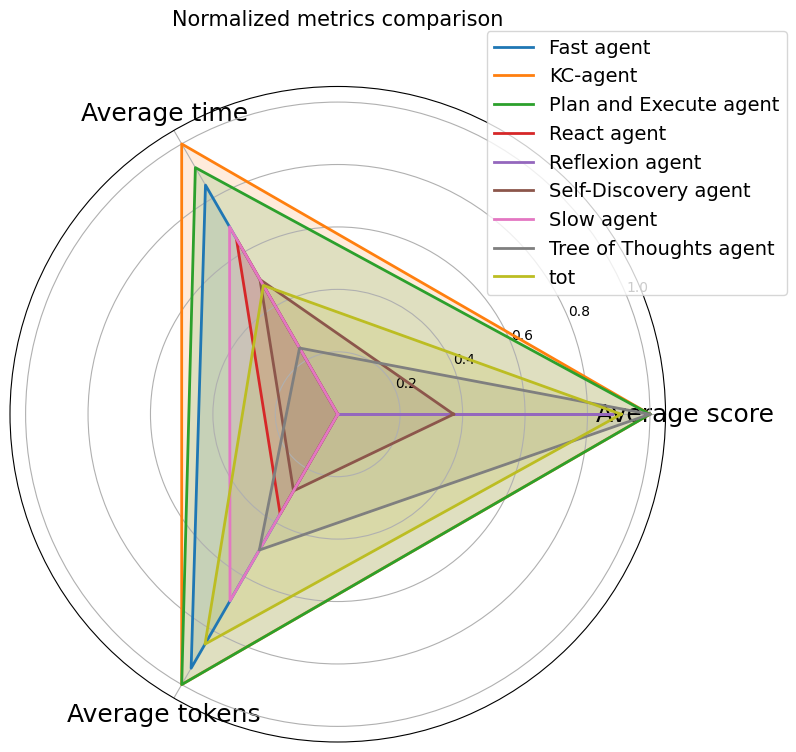

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Prepare Data for Radar Plot ---
custom_names = [
    'Fast agent',
    'KC-agent',
    'Plan and Execute agent',
    'React agent',
    'Reflexion agent',
    'Self-Discovery agent',
    'Slow agent',
    'Tree of Thoughts agent'
]
current_names = agg_df['agent'].unique()
print("Current agent names:", current_names)

# Create a mapping from current names to custom names
name_mapping = dict(zip(current_names, custom_names))
print("Mapping dictionary:", name_mapping)

# Replace the agent names in the DataFrame
agg_df['agent'] = agg_df['agent'].replace(name_mapping)

# Define the metrics for comparison.
# Here we use:
#   - 'avg_final_combined' as overall accuracy (beneficial: higher is better)
#   - 'avg_exec_time' as execution time (cost: lower is better)
#   - 'avg_tokens_used' as tokens used (cost: lower is better)
metrics = ['avg_final_combined', 'avg_exec_time', 'avg_tokens_used']

# Create a DataFrame with agent names and the selected metrics.
radar_df = agg_df[['agent'] + metrics].dropna()

# Normalize each metric:
# For beneficial metrics, use: (value - min) / (max - min)
# For cost metrics, use: (max - value) / (max - min)
norm_df = pd.DataFrame()
norm_df['agent'] = radar_df['agent']
for metric in metrics:
    min_val = radar_df[metric].min()
    max_val = radar_df[metric].max()
    if metric == 'avg_final_combined':  # Beneficial: higher is better
        norm_df[metric] = (radar_df[metric] - min_val) / (max_val - min_val)
    else:  # Cost metrics: lower is better -> invert normalization
        norm_df[metric] = (max_val - radar_df[metric]) / (max_val - min_val)

# --- Create Radar Plot ---
# Number of variables
N = len(metrics)
# Compute angle for each axis in the plot (in radians)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Set up the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each agent's normalized metrics on the radar chart
for idx, row in norm_df.iterrows():
    # Get values for each metric and complete the loop
    values = row[metrics].tolist()
    values += values[:1]
    ax.plot(angles, values, label=row['agent'], linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.15)

# Set custom category labels on the axes
custom_metric_labels = ["Average score", "Average time", "Average tokens"]
ax.set_thetagrids(np.degrees(angles[:-1]), custom_metric_labels, fontsize=18)

# Add title and legend
plt.title("Normalized metrics comparison", size=15, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=14)

plt.tight_layout()
output_dir = "paper_figures"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "radar_chart.pdf")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


In [45]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Select the metrics for the heatmap.
# # You can adjust this list with any other metrics you want to compare.
# metrics = ['avg_final_combined', 'avg_exec_time', 'avg_tokens_used']

# # Create a DataFrame for the heatmap.
# # Ensure that 'agent' is present in your aggregated DataFrame (agg_df).
# heatmap_df = agg_df[['agent'] + metrics].dropna().set_index('agent')

# # Normalize each metric using min–max normalization.
# norm_df = heatmap_df.copy()
# for col in metrics:
#     norm_df[col] = (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())

# # Plot the heatmap.
# plt.figure(figsize=(10, 6))
# sns.heatmap(norm_df, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white')
# plt.title("Heatmap of Normalized Metrics by Agent", fontsize=16)
# plt.ylabel("Agent", fontsize=12)
# plt.xlabel("Metric", fontsize=12)
# plt.tight_layout()
# plt.show()


In [13]:
agg_df

agent  total_runs  successful_runs  success_rate  \
0              Fast agent           5                5           1.0   
1                KC-agent           1                1           1.0   
2  Plan and Execute agent           3                3           1.0   
3             React agent           3                3           1.0   
4        Reflection agent           3                3           1.0   
5    Self-Discovery agent           3                3           1.0   
6              Slow agent           3                3           1.0   
7  Tree of Thoughts agent           3                3           1.0   

   avg_final_new  std_final_new  se_final_new  min_final_new  max_final_new  \
0       0.753333       0.096032      0.038413       0.633333       0.833333   
1       0.883333            NaN      0.000000       0.883333       0.883333   
2       0.816667       0.044096      0.020787       0.766667       0.850000   
3       0.688889       0.164429      0.077513       0.500000       0.800000   
4       0.711111       0.134715      0.063505       0.566667       0.833333   
5       0.825556       0.038921      0.018347       0.783333       0.860000   
6       0.783222       0.132162      0.062302       0.633333       0.883000   
7       0.766667       0.088192      0.041574       0.666667       0.833333   

   avg_final_old  ...  max_tokens_used  avg_iterations  std_iterations  \
0       0.847333  ...              970             1.0             0.0   
1       0.901667  ...              613             1.0             NaN   
2       0.813889  ...            13209             1.0             0.0   
3       0.841111  ...             5069             1.0             0.0   
4       0.825000  ...             6421             1.0             0.0   
5       0.752778  ...             5033             1.0             0.0   
6       0.861778  ...            38762             1.0             0.0   
7       0.852222  ...             2852             1.0             0.0   

   se_iterations  min_iterations  max_iterations  improvement_per_token  \
0            0.0               1               1               0.277230   
1            0.0               1               1               0.271887   
2            0.0               1               1               0.003694   
3            0.0               1               1              -0.023262   
4            0.0               1               1              -0.012148   
5            0.0               1               1               0.056786   
6            0.0               1               1               0.002545   
7            0.0               1               1               0.031937   

   improvement_per_second  avg_final_combined  se_final_combined  
0                0.011135            0.800333           0.021916  
1                0.008500            0.892500           0.000000  
2                0.000647            0.815278           0.026106  
3               -0.003123            0.765000           0.043502  
4               -0.001858            0.768056           0.033487  
5                0.005569            0.789167           0.032044  
6                0.000973            0.822500           0.034490  
7                0.001933            0.809444           0.025244  

[8 rows x 53 columns]

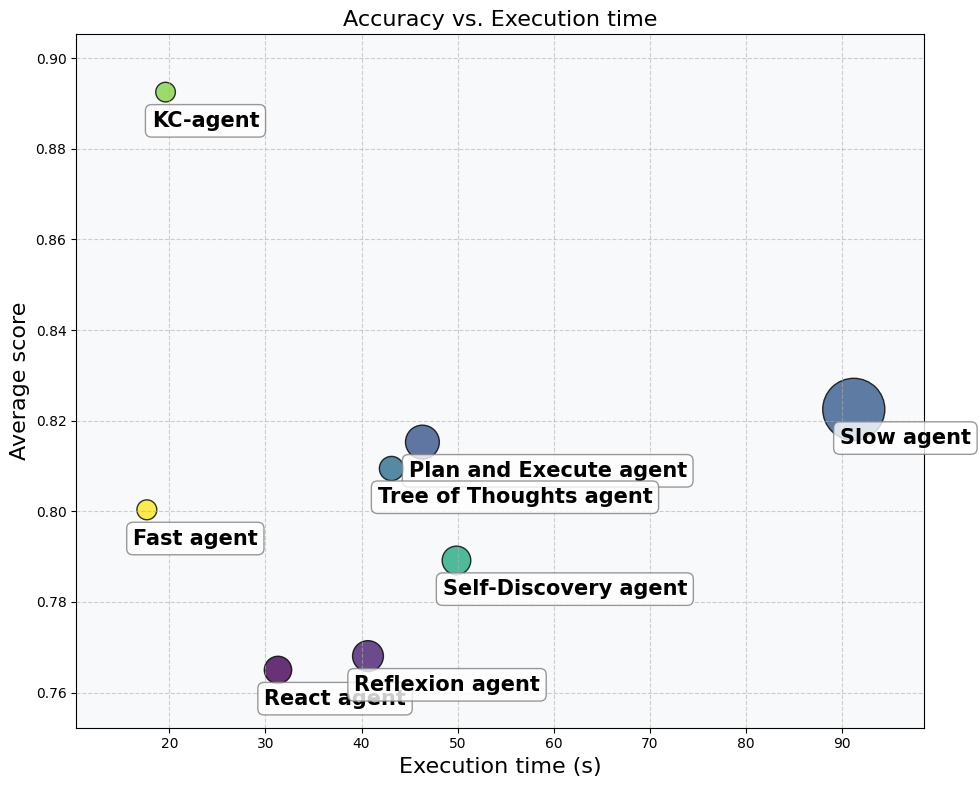

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import os
from typing import Optional

def plot_bubble_performance(agg_df: pd.DataFrame, output_dir: Optional[str] = None):
    """
    Create a refined bubble chart with:
      - X-axis: Execution Time (seconds)
      - Y-axis: Combined Accuracy
      - Bubble size: Tokens Used
      - Agent names annotated on each bubble (underscores escaped)
    
    Parameters
    ----------
    agg_df : pd.DataFrame
        Aggregated metrics DataFrame.
    output_dir : str, optional
        Directory to save the plot.
    """
    # custom_names = [
    #     'Fast',
    #     'Improver',
    #     'Plan and Execute',
    #     'React',
    #     'Reflection',
    #     'Self Discovery',
    #     'Slow',
    #     'Tree of Thoughts'
    # ]
    # current_names = agg_df['agent'].unique()
    # print("Current agent names:", current_names)

    # # Create a mapping from current names to custom names
    # name_mapping = dict(zip(current_names, custom_names))
    # print("Mapping dictionary:", name_mapping)

    # # Replace the agent names in the DataFrame
    # agg_df['agent'] = agg_df['agent'].replace(name_mapping)

    # Check required columns
    required = ['agent', 'avg_final_combined', 'avg_exec_time', 'avg_tokens_used']
    for col in required:
        if col not in agg_df.columns:
            warnings.warn(f"Column '{col}' is required but not found in the DataFrame.")
            return
    
    # Drop rows with missing values in required columns
    valid_df = agg_df.dropna(subset=required)
    if len(valid_df) < 2:
        warnings.warn("Not enough valid data points for the bubble chart.")
        return
    
    # Compute bubble sizes based on tokens used (normalize to a size range)
    tokens = valid_df['avg_tokens_used']
    min_tokens, max_tokens = tokens.min(), tokens.max()
    # Scale bubble sizes between 200 and 2000 (adjust as needed)
    bubble_size = ((tokens - min_tokens) / (max_tokens - min_tokens)) * 1800 + 200

    # Use a color gradient if 'improvement_per_second' exists; otherwise, use sequential colors.
    if 'improvement_per_second' in valid_df.columns:
        efficiency = valid_df['improvement_per_second']
        norm = plt.Normalize(efficiency.min(), efficiency.max())
        colors = plt.cm.viridis(norm(efficiency))
    else:
        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(valid_df)))
    
    # Create the bubble chart
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(
        valid_df['avg_exec_time'],
        valid_df['avg_final_combined'],
        s=bubble_size,
        c=colors,
        alpha=0.8,
        edgecolors='black',
        linewidths=1.0
    )
    
    # Annotate each bubble with the agent name (escape underscores)
    for i, row in valid_df.iterrows():
        agent_name = row['agent'].replace('_', '\\_')
        ax.annotate(
            agent_name,
            (row['avg_exec_time'], row['avg_final_combined']),
            xytext=(-10, -25),
            textcoords='offset points',
            fontsize=15,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    
    # Set axis labels and title
    ax.set_xlabel('Execution time (s)', fontsize=16)
    ax.set_ylabel('Average score', fontsize=16)
    ax.set_title('Accuracy vs. Execution time', fontsize=16)
    
    # Set axis limits with some padding
    x = valid_df['avg_exec_time']
    y = valid_df['avg_final_combined']
    x_padding = (x.max() - x.min()) * 0.1
    y_padding = (y.max() - y.min()) * 0.1
    ax.set_xlim(x.min() - x_padding, x.max() + x_padding)
    ax.set_ylim(y.min() - y_padding, y.max() + y_padding)
    
    # Aesthetics: add grid and set background color
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    
    # Save the figure if an output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "bubble_performance_vs_cost.pdf")
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Example usage:
plot_bubble_performance(agg_df, output_dir="paper_figures")
